In [42]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from scipy.io import loadmat
from sklearn.model_selection import train_test_split                 
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb
from sklearn import preprocessing   
from sklearn.metrics import accuracy_score,roc_auc_score,auc,confusion_matrix,roc_curve
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler,SMOTE,SMOTENC,ADASYN,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [43]:
m = loadmat("OCD_90_200_fMRI.mat") 

In [44]:
min_max_scaler = preprocessing.MinMaxScaler()
OCD=np.zeros((m['OCD'].shape[0],90,200))
for i in range(m['OCD'].shape[0]):
    OCD[i]= min_max_scaler.fit_transform(m['OCD'][i][:,0:200])
    #OCD[i]= m['OCD'][i][:,0:200]
    #OCD[i]= preprocessing.scale(m['OCD'][i][:,0:200], axis=0)
NC=np.zeros((m['NC'].shape[0],90,200))
for i in range(m['NC'].shape[0]):
    NC[i]= min_max_scaler.fit_transform(m['NC'][i][:,0:200])
    #NC[i]= m['NC'][i][:,0:200]
    #NC[i]= preprocessing.scale(m['NC'][i][:,0:200], axis=0)

In [45]:
label_OCD = [0]*m['OCD'].shape[0]
label_NC = [1]*m['NC'].shape[0]
OCD = OCD.tolist()
NC = NC.tolist()
df = OCD + NC
label = label_OCD+ label_NC
df = np.array(df)
print(df.shape)
label = np.array(label)
OCD = np.array(OCD)
dataset=OCD
print(OCD.shape)
NC = np.array(NC)
label_AD=np.array(label_OCD)
label_NC=np.array(label_NC)

(82, 90, 200)
(62, 90, 200)


D:\Anaconda\envs\lab\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\envs\lab\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


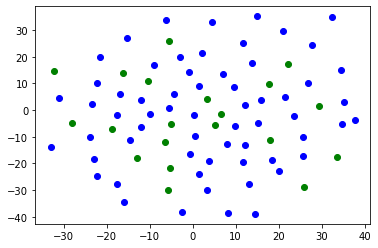

In [46]:
tsne = TSNE(n_components=2)#tsne降维
#pca = PCA(n_components=10)
tsne_df=tsne.fit_transform(df.reshape(df.shape[0],-1))
#pca_df=pca.fit_transform(df.reshape(df.shape[0],-1))
#print(tsne_df[:374,0])
plt.scatter(tsne_df[:62,0],tsne_df[:62,1],c='b')
#plt.scatter(tsne_df[1][0],tsne_df[1][1],c='b')
#plt.scatter(tsne_df[2][0],tsne_df[2][1],c='b')
#plt.scatter(tsne_df[3][0],tsne_df[3][1],c='b')
#plt.scatter(tsne_df[4][0],tsne_df[4][1],c='b')
plt.scatter(tsne_df[62:,0],tsne_df[62:,1],c='g')
plt.show()

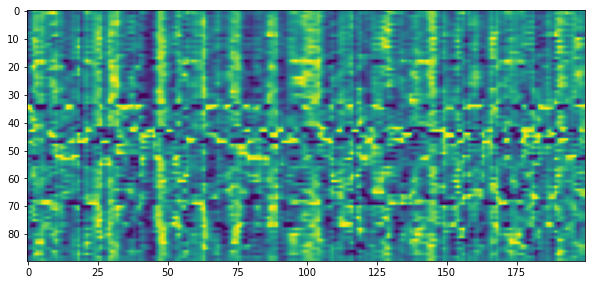

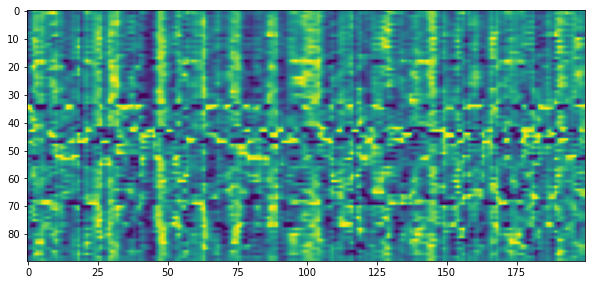

In [47]:
fig = plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
plt.imshow(min_max_scaler.fit_transform(df[0]))
plt.show()
fig = plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
plt.imshow(df[0])
plt.show()

In [48]:
x_train,x_test,y_train,y_test = train_test_split(df , label, test_size = 0.1)  

In [49]:
def progress(data):
    data = data[:,15:]
    #print(data.shape)
    data = np.corrcoef(data)
    data = np.tril(data)
    len = data.shape[0]
    new_data = []
    for i in range(len):
        for j in range(i):
            new_data.append(data[i, j])
    data = np.asarray([new_data])
    data = data.astype(np.float32)
    return data

In [50]:
train_dataset=np.zeros((x_train.shape[0],4005))
for i in range(x_train.shape[0]):
    train_dataset[i]=progress(x_train[i])
    #train_dataset[i][np.where(train_dataset[i]<train_dataset[i].mean())]=0
test_dataset=np.zeros((x_test.shape[0],4005))
for i in range(x_test.shape[0]):
    #print(x_test[i].shape)
    test_dataset[i]=progress(x_test[i])
    #test_dataset[i][np.where(test_dataset[i]<test_dataset[i].mean())]=0

In [51]:
class GetLoader(torch.utils.data.Dataset):

    def __init__(self, data_root, data_label):
        self.data = data_root
        self.label = data_label

    # index是根据batchsize划分数据后得到的索引，最后将data和对应的labels进行一起返回
    def __getitem__(self, index):
        #print(np.array(self.data).shape)
        #print(index)
        #print(np.array(self.label).shape)
        data = self.data[index]
        labels = self.label[index]
        return data, labels

    # 该函数返回数据大小长度，目的是DataLoader方便划分，如果不知道大小，DataLoader会一脸懵逼
    def __len__(self):
        return len(self.data)

In [91]:
def model_train_test(this_train_x,this_train_y,this_test_x,this_test_y):
    train_dataset=np.zeros((this_train_x.shape[0],4005))
    for i in range(this_train_x.shape[0]):
        train_dataset[i]=progress(this_train_x[i])
        train_dataset[i][np.where(train_dataset[i]<train_dataset[i].mean())]=train_dataset[i].mean()
    test_dataset=np.zeros((this_test_x.shape[0],4005))
    for i in range(this_test_x.shape[0]):
        #print(x_test[i].shape)
        test_dataset[i]=progress(this_test_x[i])
        test_dataset[i][np.where(test_dataset[i]<test_dataset[i].mean())]=test_dataset[i].mean()
    
    acc_total_train = 0
    acc_total_test = 0
    model = SVC(C=0.8,kernel='poly', degree=3)
    ros=RandomOverSampler(random_state=0) #采用随机过采样（上采样）
    rus=RandomUnderSampler(random_state=0,replacement=True) #采用随机欠采样（下采样）
    #train_dataset,this_train_y=ros.fit_resample(train_dataset,this_train_y)
    #train_dataset,this_train_y=rus.fit_resample(train_dataset,this_train_y)
    #print(train_dataset.shape)
    #model = RandomForestClassifier(random_state=0,n_estimators=100,max_features=10)
    #model = KNeighborsClassifier(n_neighbors=2, weights='uniform')
    model.fit(train_dataset, this_train_y)

    pred = model.predict(train_dataset)
    acc = accuracy_score(this_train_y, pred)
    acc_total_train += acc
    fpr_train,tpr_train,threshold_train = roc_curve(this_train_y, pred) 
    roc_auc_train = auc(fpr_train,tpr_train)
    pred = model.predict(test_dataset)
    acc = accuracy_score(this_test_y, pred)
    fpr,tpr,threshold = roc_curve(this_test_y, pred) 
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='test ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr_train, tpr_train, color='red',
         lw=lw, label='train ROC curve (area = %0.2f)' % roc_auc_train) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    if(len(set(this_test_y))!=1):
        roc=roc_auc_score(this_test_y, pred)
        sensitivity=confusion_matrix(this_test_y, pred)[0][0]/(confusion_matrix(this_test_y, pred)[0][0]+confusion_matrix(this_test_y, pred)[0][1])
        specificity=confusion_matrix(this_test_y, pred)[1][1]/(confusion_matrix(this_test_y, pred)[1][1]+confusion_matrix(this_test_y, pred)[1][0])
    else:
        roc=0
        sensitivity=0
        specificity=0
    acc_total_test += acc
    print('\n 训练集',acc_total_train, '测试集', acc_total_test)
    return acc_total_test,acc_total_train,roc,sensitivity,specificity

In [92]:
def kfold_train_test(n):
    from sklearn.model_selection import KFold
    accuracy = list()   
    train_accuracy = [] 
    roc_all=[]
    sensitivity_all=[]
    specificity_all=[]
    k =10    #10折交叉验证重复k次
    for i in range(k):
        kfold = KFold(n_splits=n,shuffle=True)
        for train_index, test_index in kfold.split(df, label):
            # train_index 就是分类的训练集的下标，test_index 就是分配的验证集的下标
            this_train_x, this_train_y = df[train_index], label[train_index]  # 本组训练集
            this_test_x, this_test_y = df[test_index], label[test_index]  # 本组验证集
            # 训练本组的数据，并计算准确率
            acc,train_acc,roc,sensitivity,specificity=model_train_test(this_train_x,this_train_y,this_test_x,this_test_y)
            accuracy.append(acc)
            train_accuracy.append(train_acc)
            print('roc:',roc)
            print('sensitivity:',sensitivity)
            print('specificity:',specificity)
            roc_all.append(roc)
            sensitivity_all.append(sensitivity)
            specificity_all.append(specificity)
            #print(accuracy)  # 得到预测结果区间[0,1]
    roc_all=np.array(roc_all)
    roc_all=roc_all[np.nonzero(roc_all)]
    sensitivity_all=np.array(sensitivity_all)
    sensitivity_all=sensitivity_all[np.nonzero(sensitivity_all)]
    specificity_all=np.array(specificity_all)
    specificity_all=specificity_all[np.nonzero(specificity_all)]
    print('average test accuracy:',np.array(accuracy).sum()/(k*n))
    print('average train accuracy:',np.array(train_accuracy).sum()/(k*n))
    print('average roc:',np.array(roc_all).sum()/np.array(roc_all).shape[0])
    print('average sensitivity:',np.array(sensitivity_all).sum()/np.array(sensitivity_all).shape[0])
    print('average specificity:',np.array(specificity_all).sum()/np.array(specificity_all).shape[0])
    plt.plot(np.array(accuracy))
    plt.plot(np.array(train_accuracy))

<Figure size 432x288 with 0 Axes>

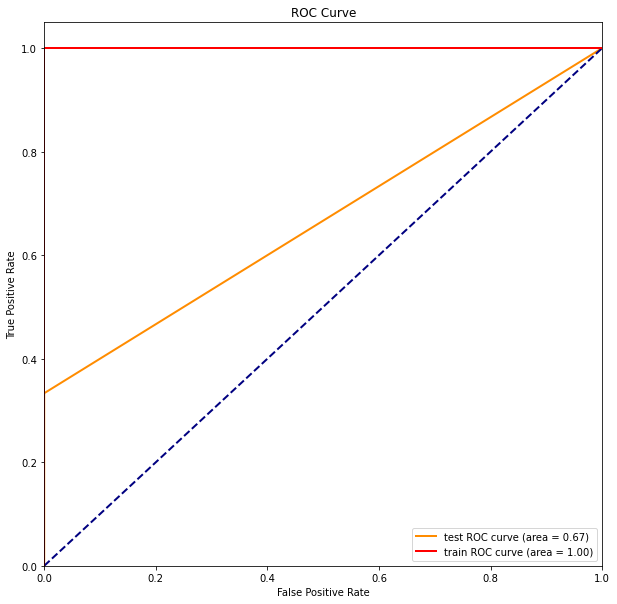


 训练集 1.0 测试集 0.7777777777777778
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

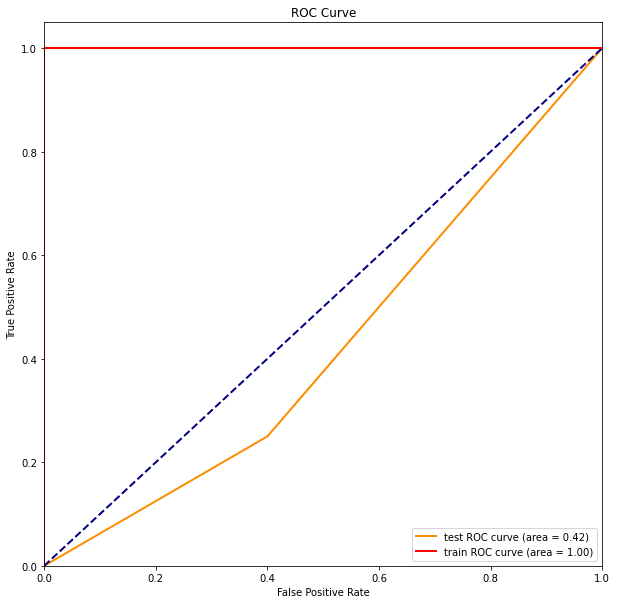


 训练集 1.0 测试集 0.4444444444444444
roc: 0.425
sensitivity: 0.6
specificity: 0.25


<Figure size 432x288 with 0 Axes>

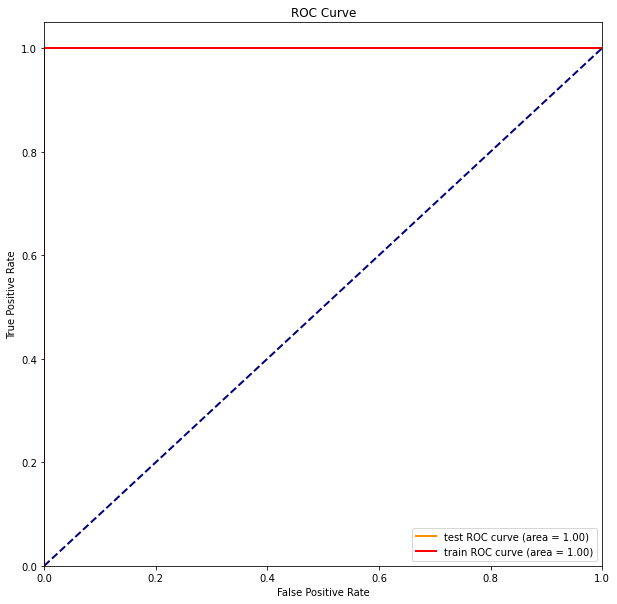


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

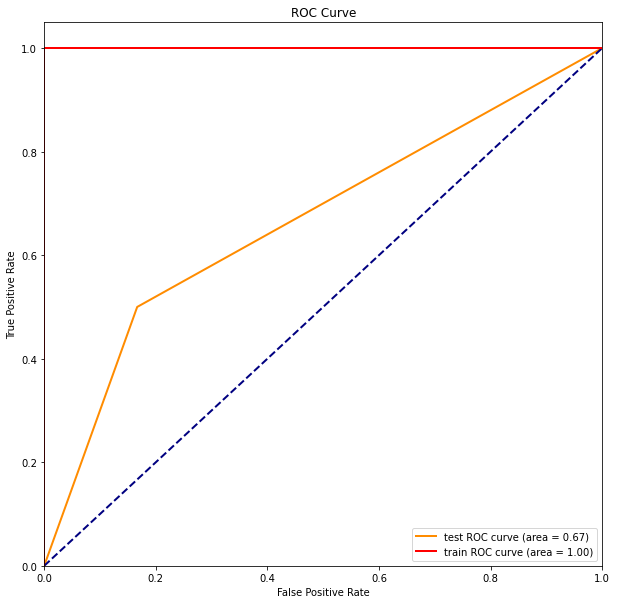


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 0.8333333333333334
specificity: 0.5


<Figure size 432x288 with 0 Axes>

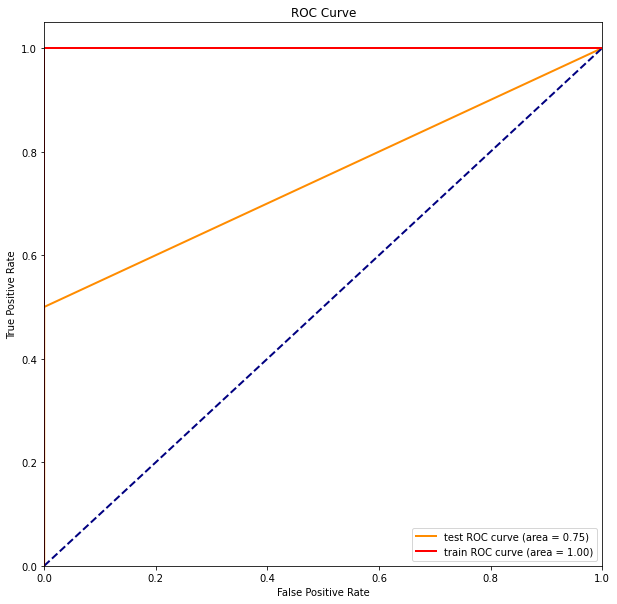


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

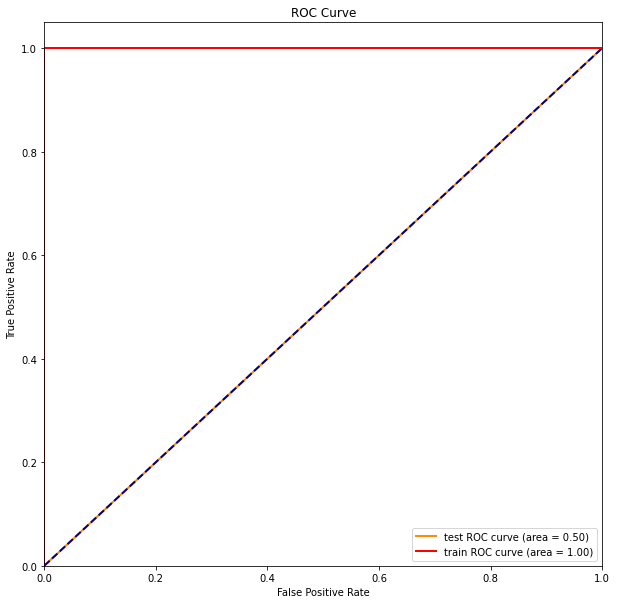


 训练集 1.0 测试集 0.875
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

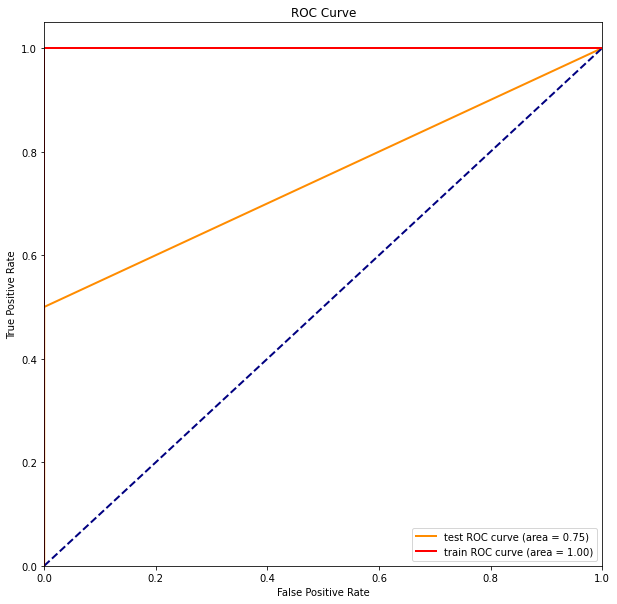


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

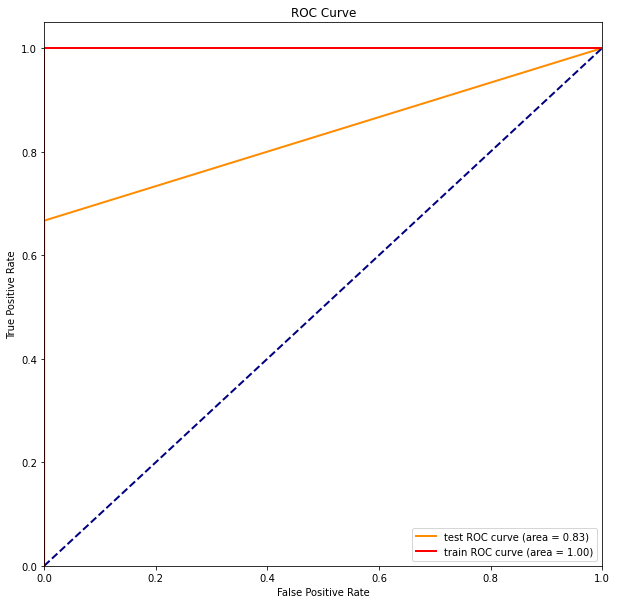


 训练集 1.0 测试集 0.875
roc: 0.8333333333333333
sensitivity: 1.0
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

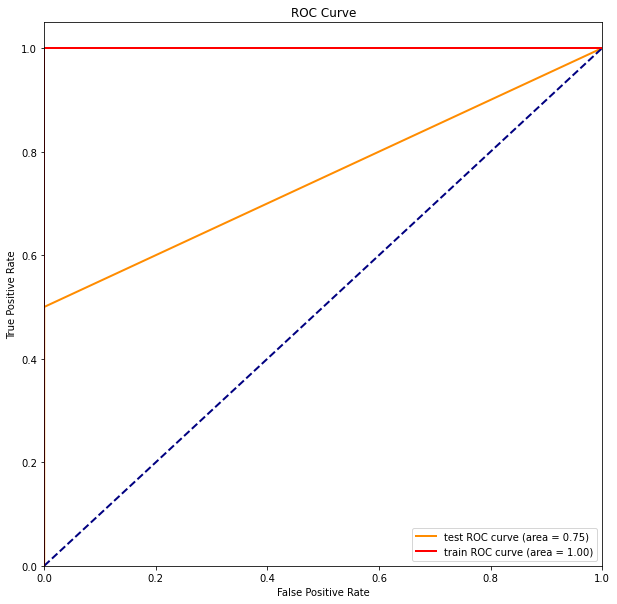


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


D:\Anaconda\envs\lab\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


<Figure size 432x288 with 0 Axes>

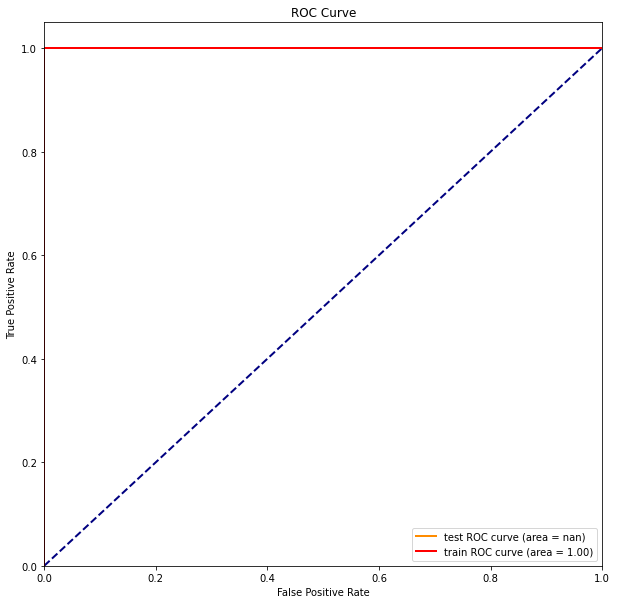


 训练集 1.0 测试集 1.0
roc: 0
sensitivity: 0
specificity: 0


<Figure size 432x288 with 0 Axes>

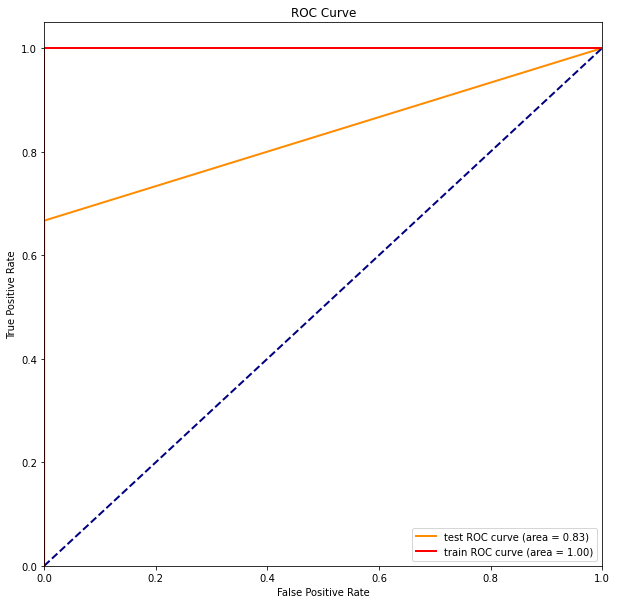


 训练集 1.0 测试集 0.8888888888888888
roc: 0.8333333333333333
sensitivity: 1.0
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

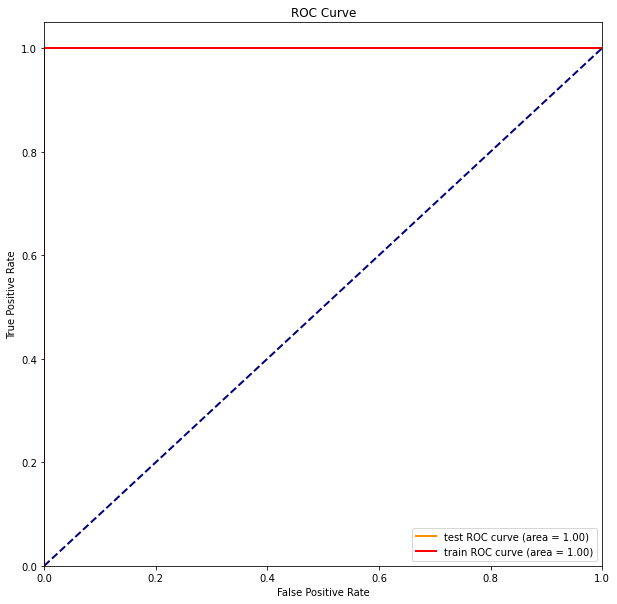


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

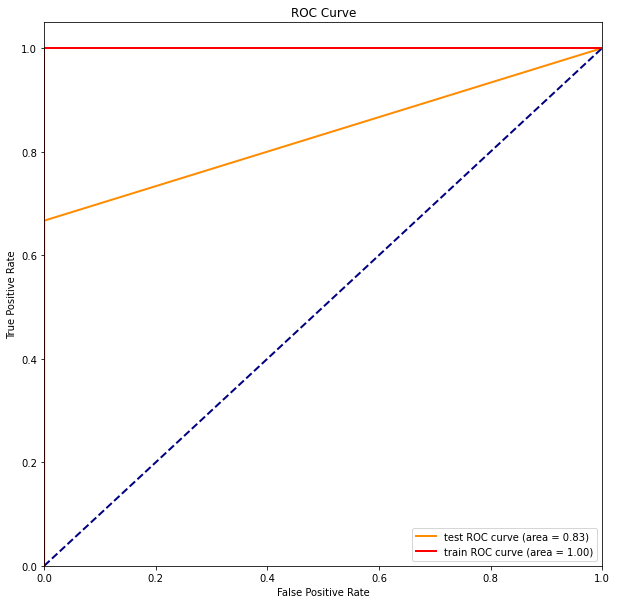


 训练集 1.0 测试集 0.875
roc: 0.8333333333333333
sensitivity: 1.0
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

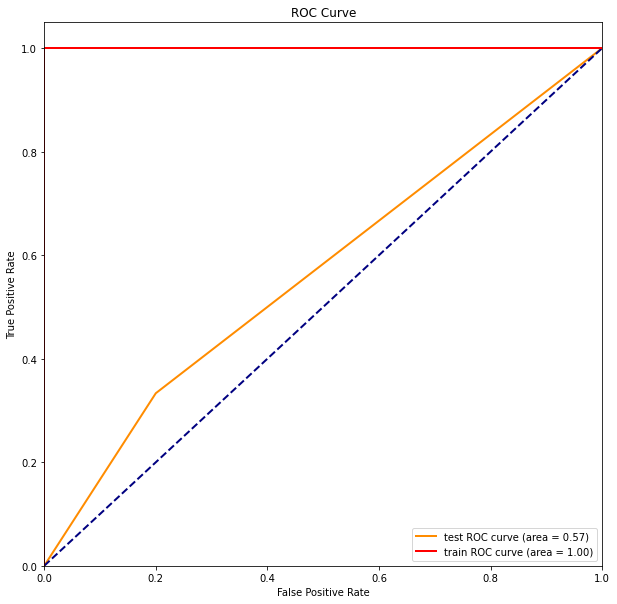


 训练集 1.0 测试集 0.625
roc: 0.5666666666666667
sensitivity: 0.8
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

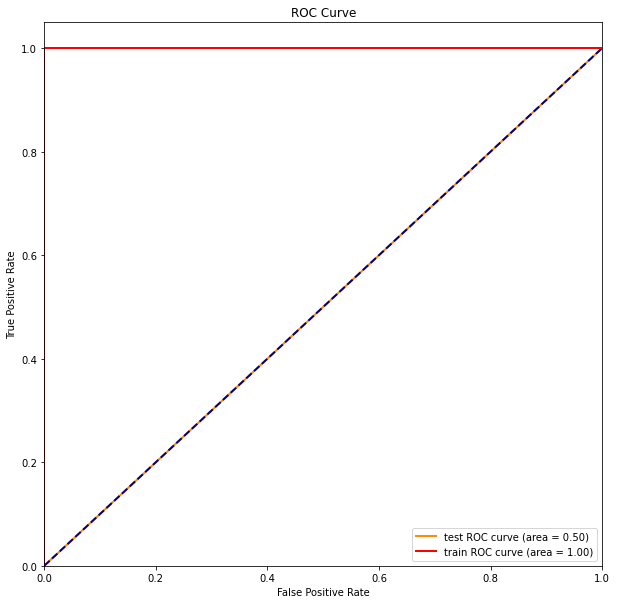


 训练集 1.0 测试集 0.75
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

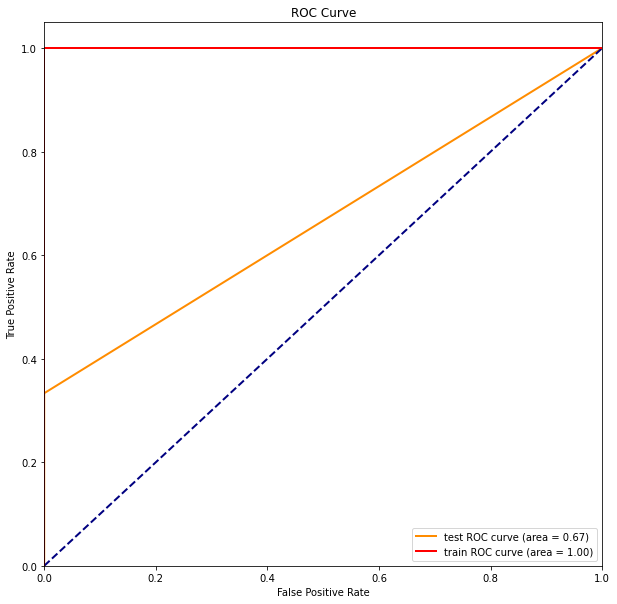


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


D:\Anaconda\envs\lab\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


<Figure size 432x288 with 0 Axes>

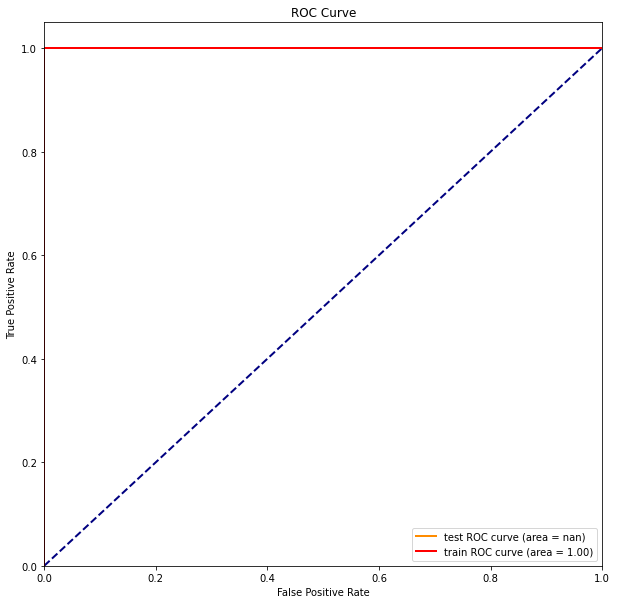


 训练集 1.0 测试集 1.0
roc: 0
sensitivity: 0
specificity: 0


<Figure size 432x288 with 0 Axes>

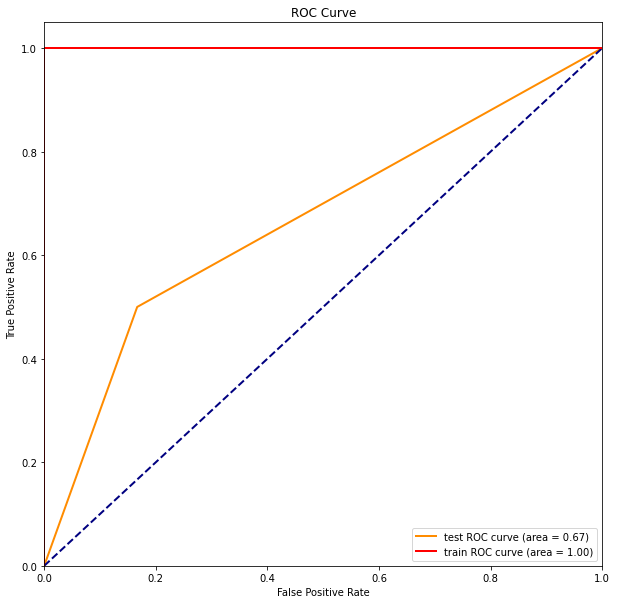


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 0.8333333333333334
specificity: 0.5


<Figure size 432x288 with 0 Axes>

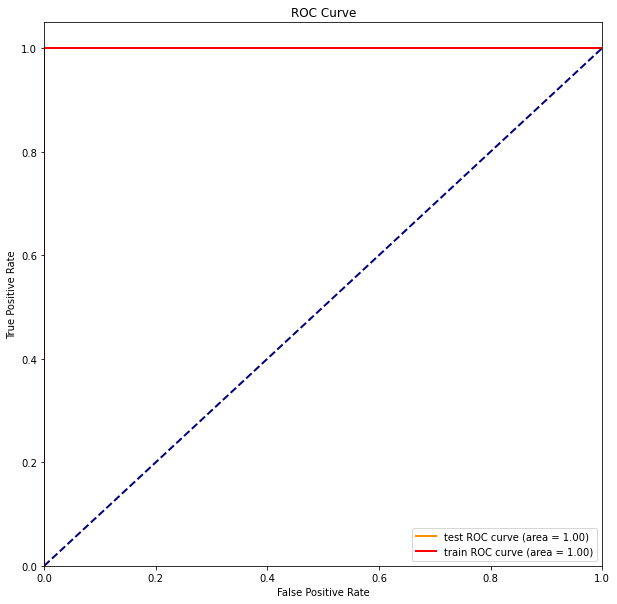


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

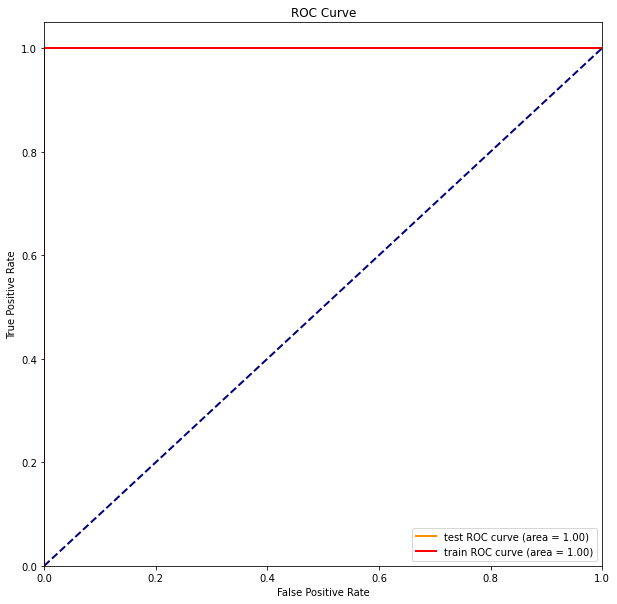


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


D:\Anaconda\envs\lab\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


<Figure size 432x288 with 0 Axes>

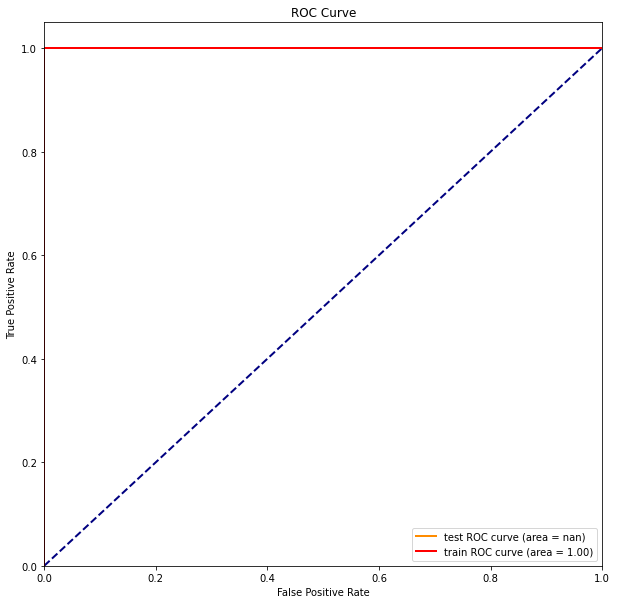


 训练集 1.0 测试集 0.8888888888888888
roc: 0
sensitivity: 0
specificity: 0


<Figure size 432x288 with 0 Axes>

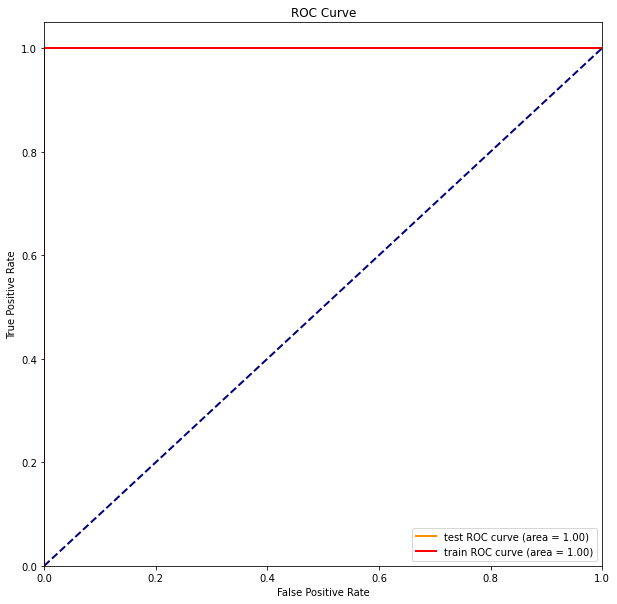


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

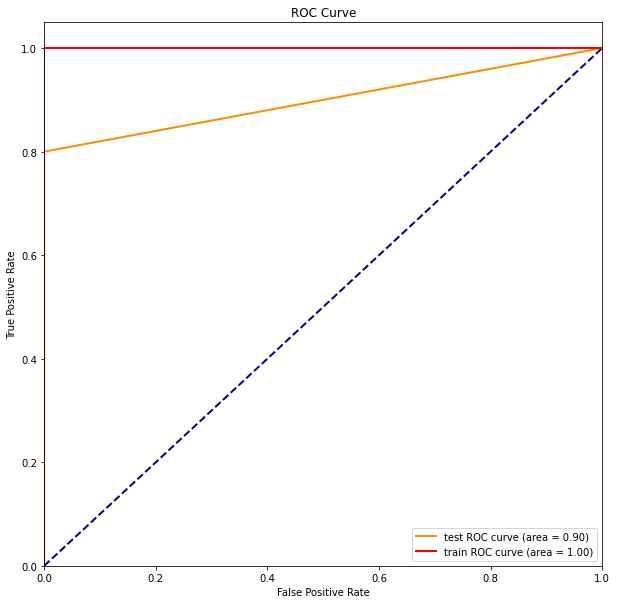


 训练集 1.0 测试集 0.875
roc: 0.9
sensitivity: 1.0
specificity: 0.8


<Figure size 432x288 with 0 Axes>

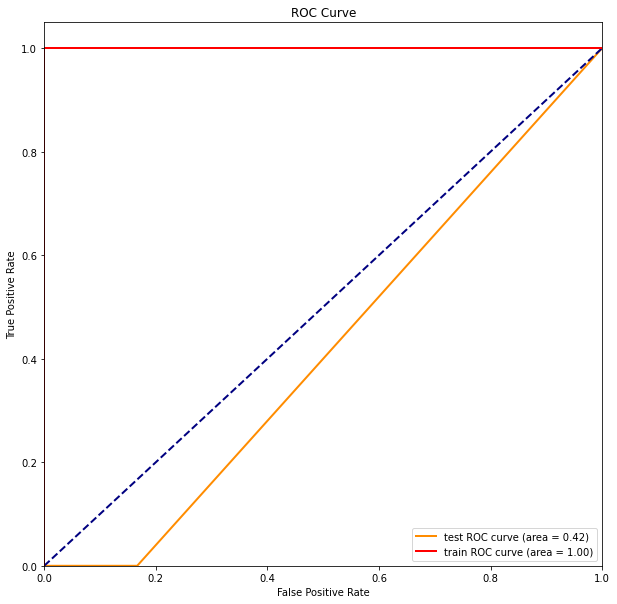


 训练集 1.0 测试集 0.625
roc: 0.4166666666666667
sensitivity: 0.8333333333333334
specificity: 0.0


<Figure size 432x288 with 0 Axes>

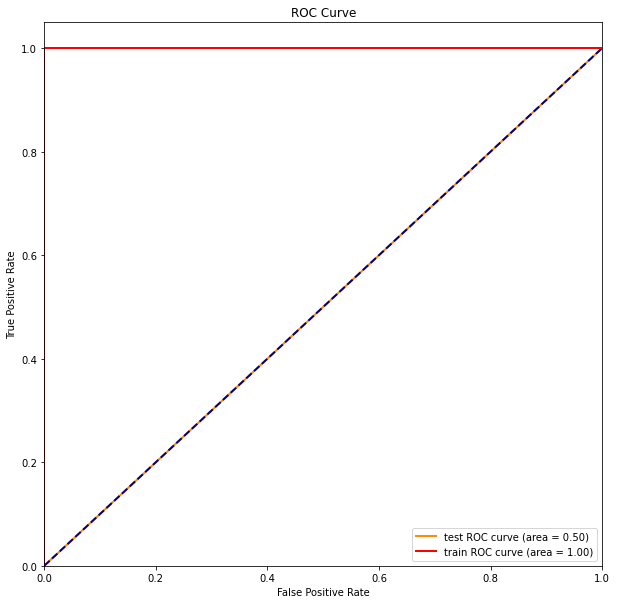


 训练集 1.0 测试集 0.875
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

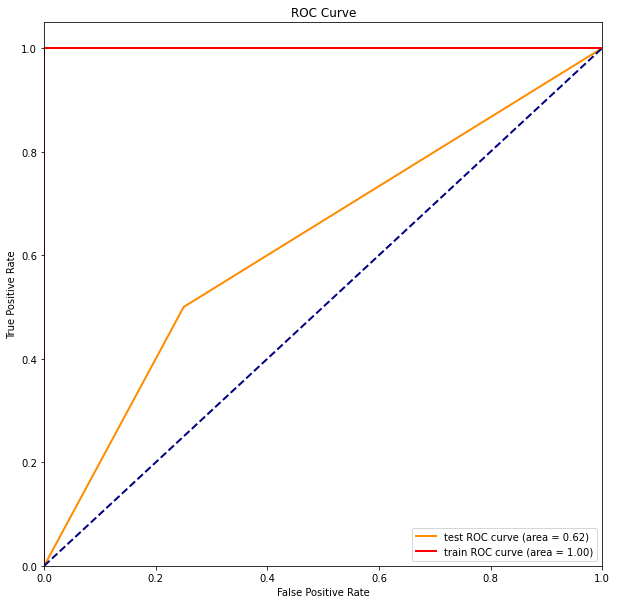


 训练集 1.0 测试集 0.625
roc: 0.625
sensitivity: 0.75
specificity: 0.5


<Figure size 432x288 with 0 Axes>

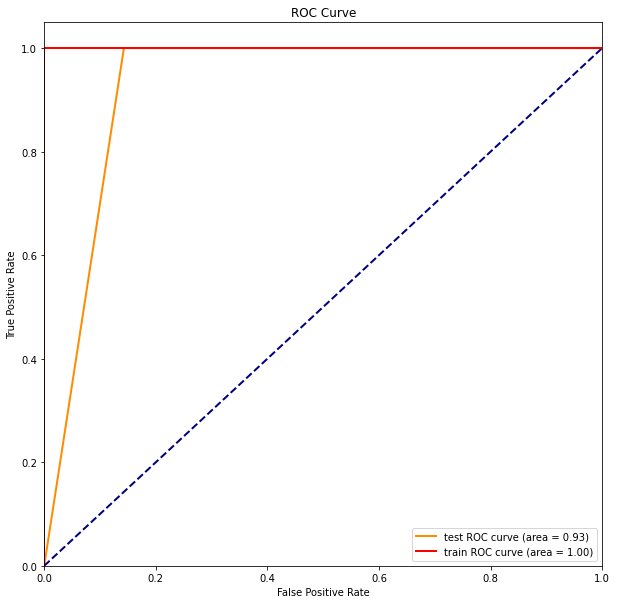


 训练集 1.0 测试集 0.875
roc: 0.9285714285714286
sensitivity: 0.8571428571428571
specificity: 1.0


<Figure size 432x288 with 0 Axes>

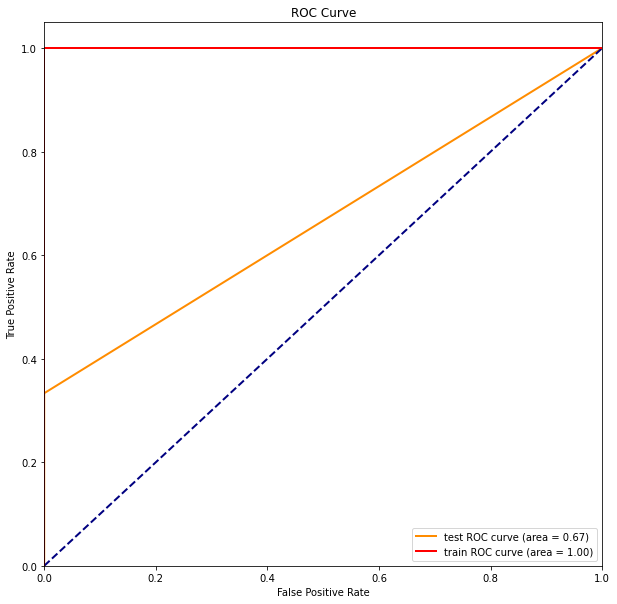


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

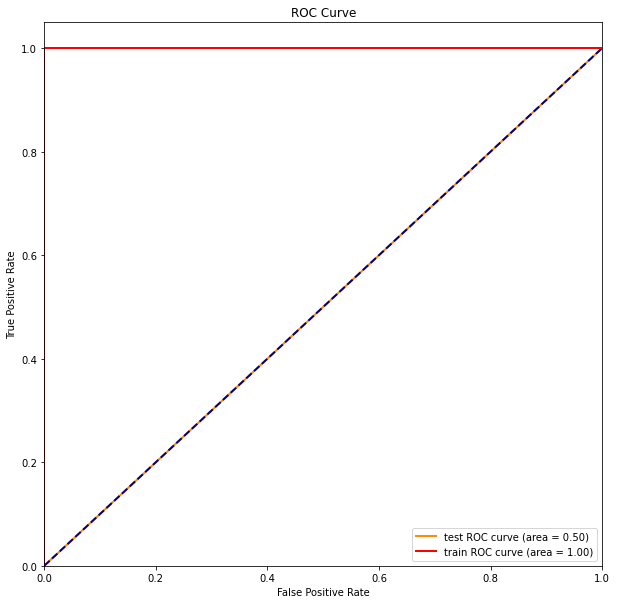


 训练集 1.0 测试集 0.75
roc: 0.5
sensitivity: 1.0
specificity: 0.0


D:\Anaconda\envs\lab\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


<Figure size 432x288 with 0 Axes>

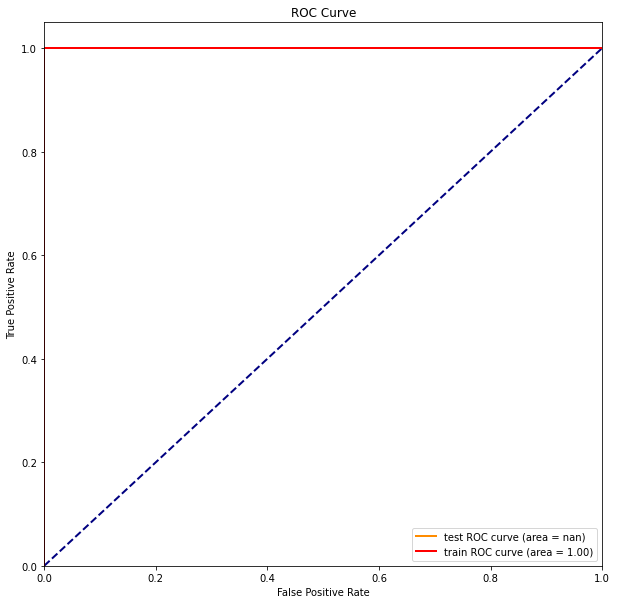


 训练集 1.0 测试集 1.0
roc: 0
sensitivity: 0
specificity: 0


<Figure size 432x288 with 0 Axes>

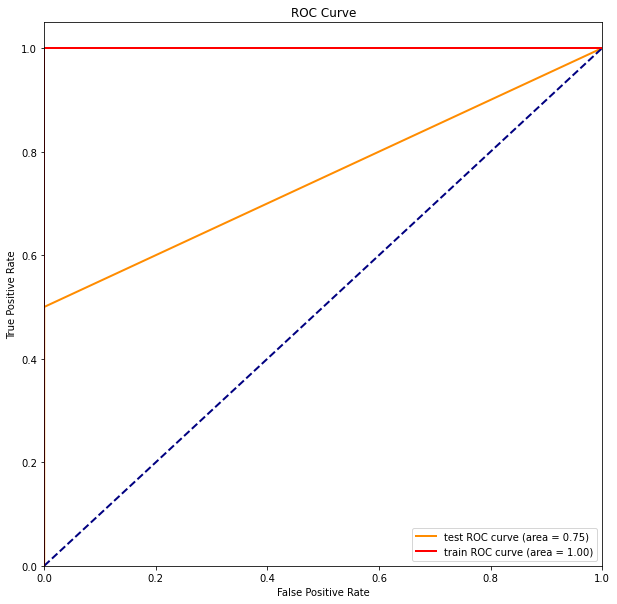


 训练集 1.0 测试集 0.8888888888888888
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

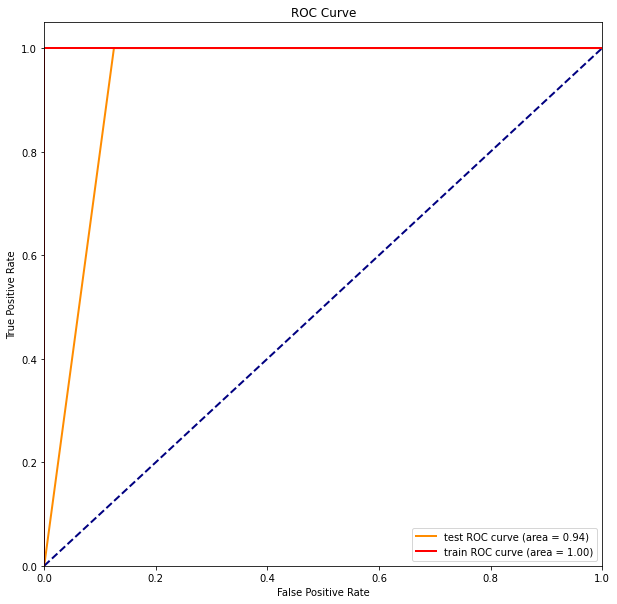


 训练集 1.0 测试集 0.8888888888888888
roc: 0.9375
sensitivity: 0.875
specificity: 1.0


<Figure size 432x288 with 0 Axes>

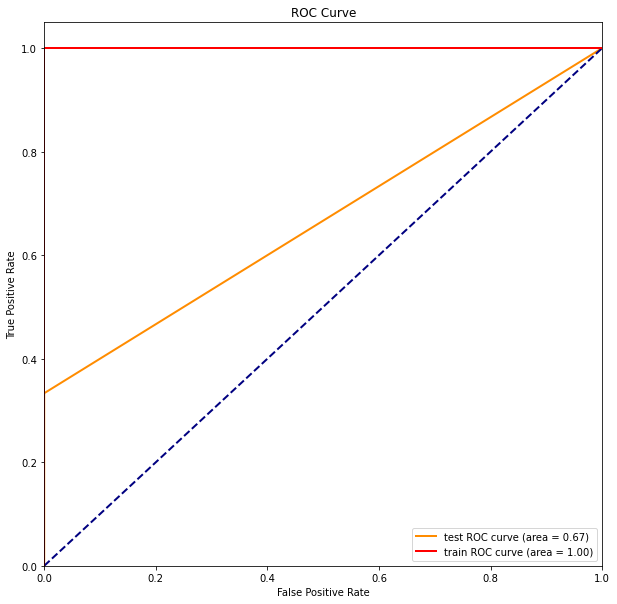


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

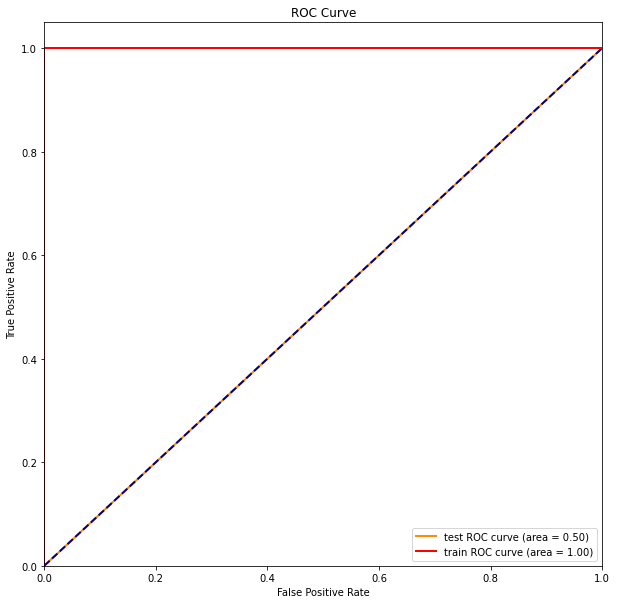


 训练集 1.0 测试集 0.75
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

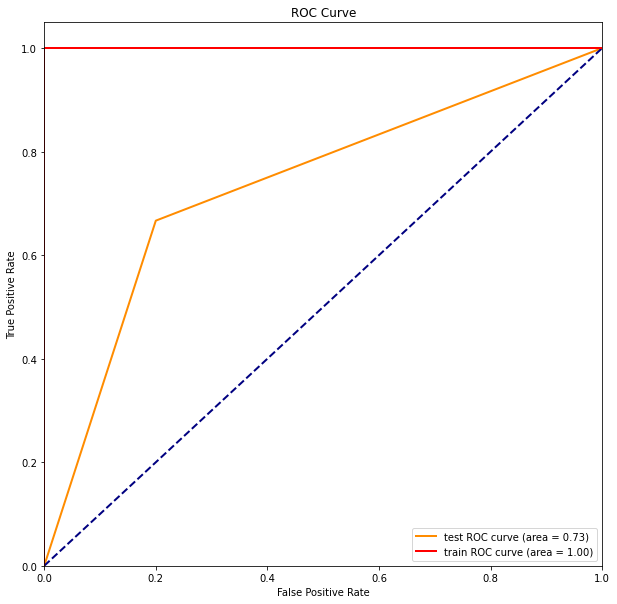


 训练集 1.0 测试集 0.75
roc: 0.7333333333333333
sensitivity: 0.8
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

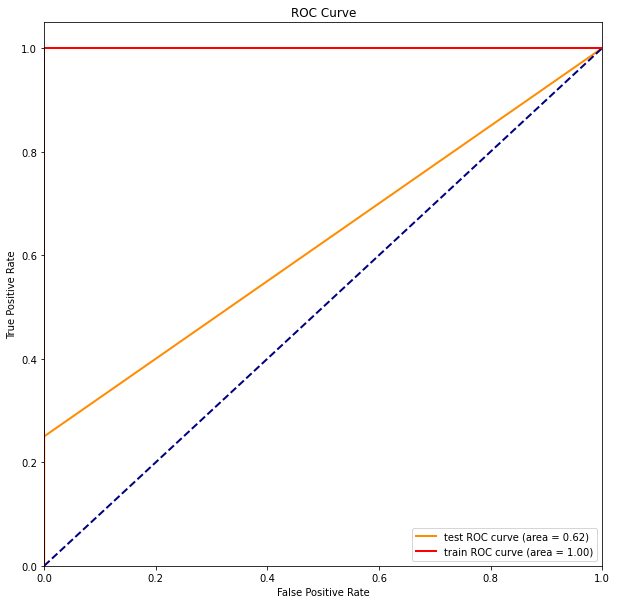


 训练集 1.0 测试集 0.625
roc: 0.625
sensitivity: 1.0
specificity: 0.25


D:\Anaconda\envs\lab\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


<Figure size 432x288 with 0 Axes>

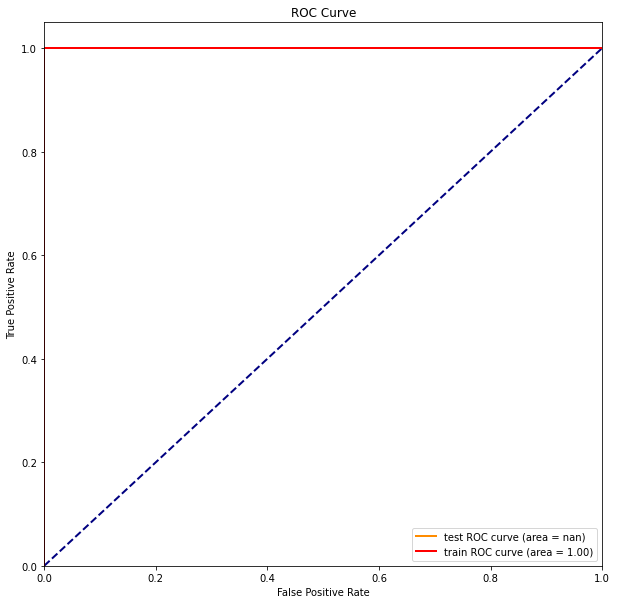


 训练集 1.0 测试集 1.0
roc: 0
sensitivity: 0
specificity: 0


<Figure size 432x288 with 0 Axes>

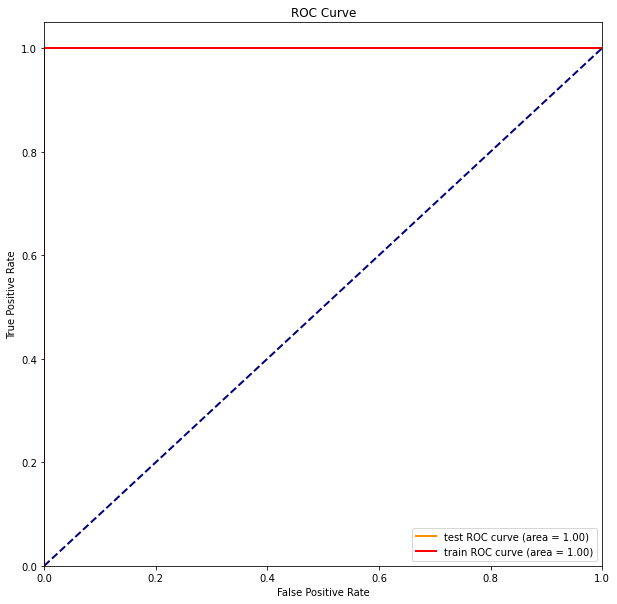


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

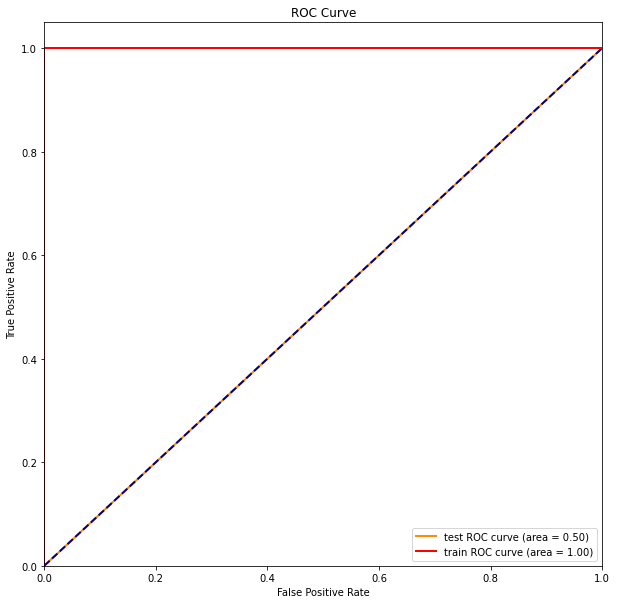


 训练集 1.0 测试集 0.875
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

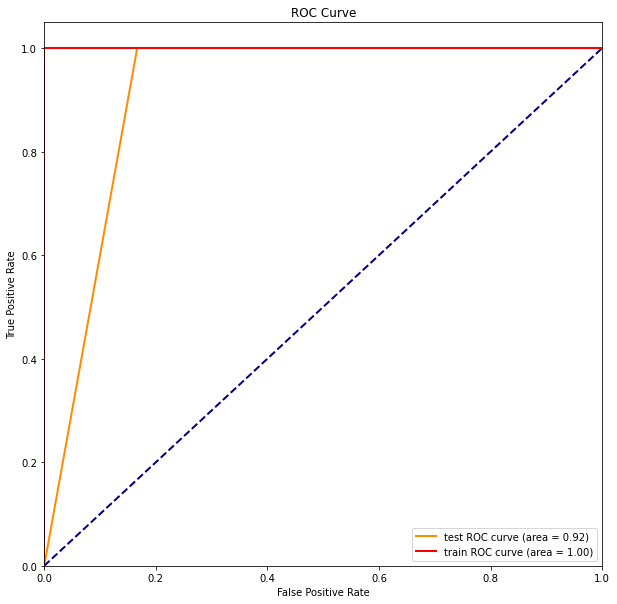


 训练集 1.0 测试集 0.875
roc: 0.9166666666666667
sensitivity: 0.8333333333333334
specificity: 1.0


<Figure size 432x288 with 0 Axes>

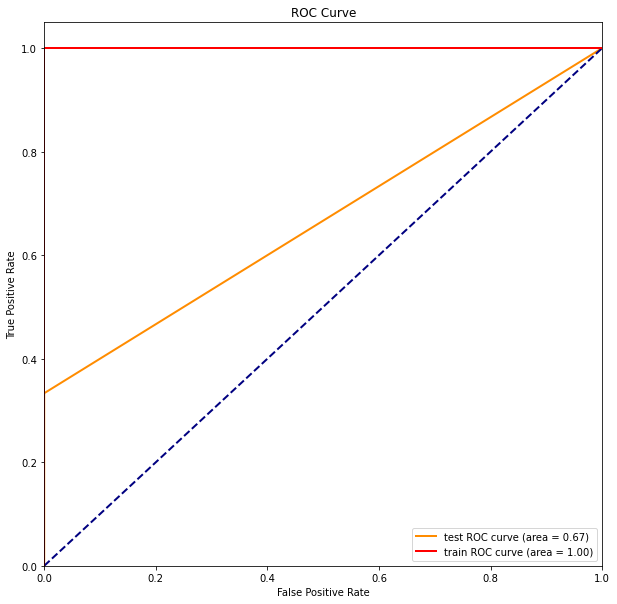


 训练集 1.0 测试集 0.7777777777777778
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

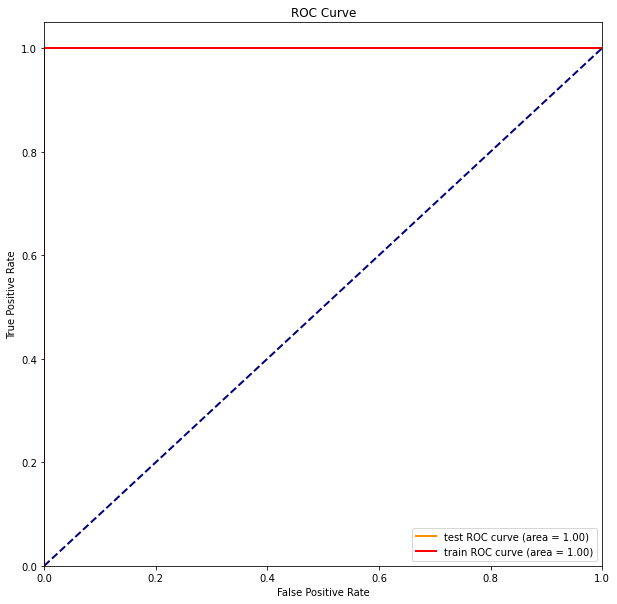


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

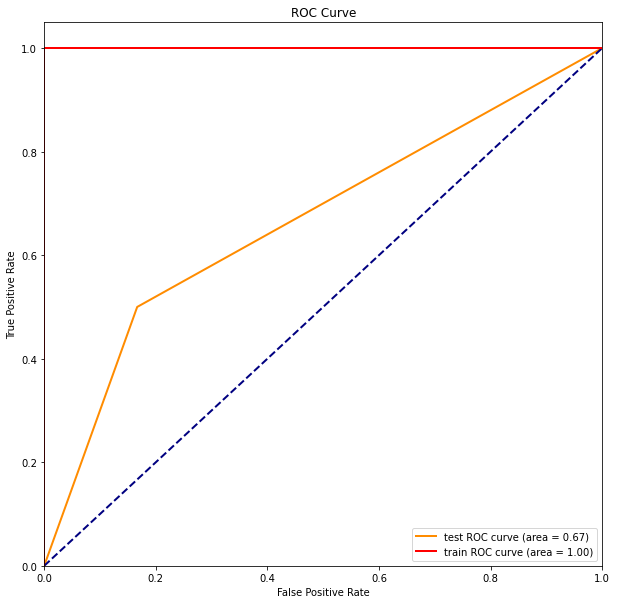


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 0.8333333333333334
specificity: 0.5


<Figure size 432x288 with 0 Axes>

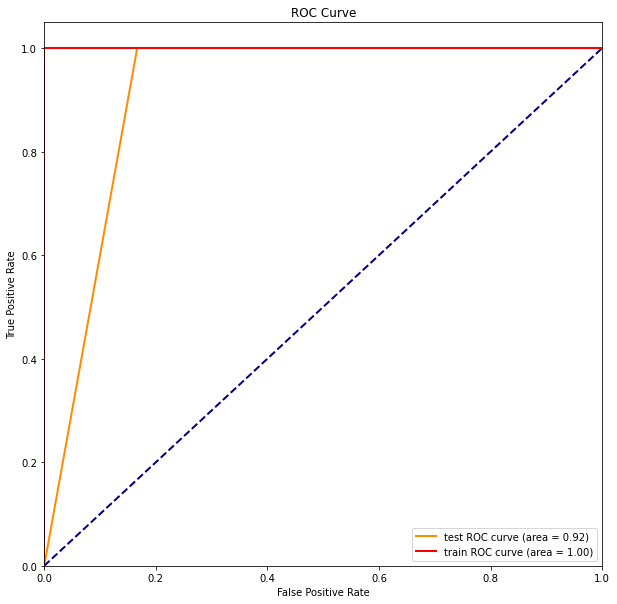


 训练集 1.0 测试集 0.875
roc: 0.9166666666666667
sensitivity: 0.8333333333333334
specificity: 1.0


<Figure size 432x288 with 0 Axes>

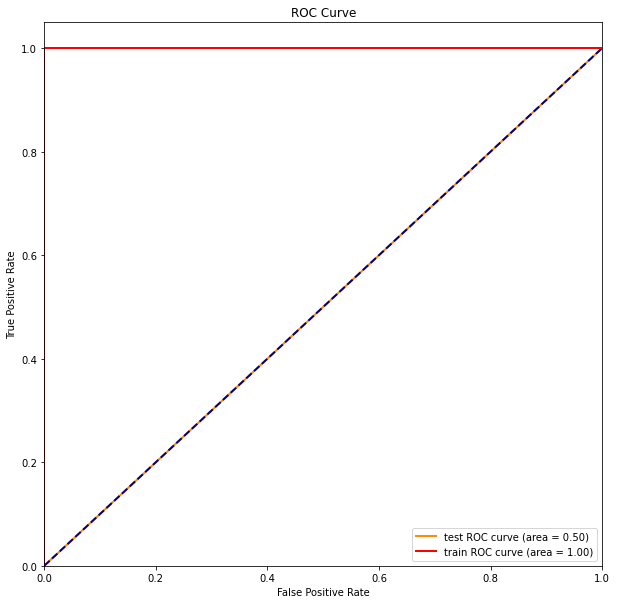


 训练集 1.0 测试集 0.875
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

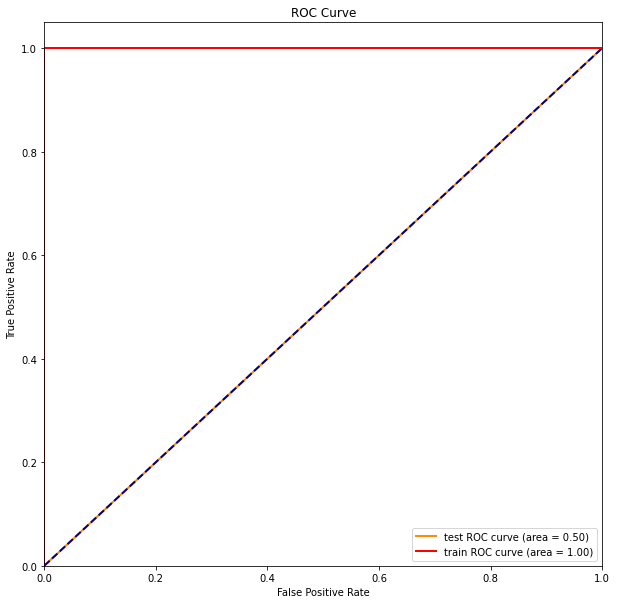


 训练集 1.0 测试集 0.75
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

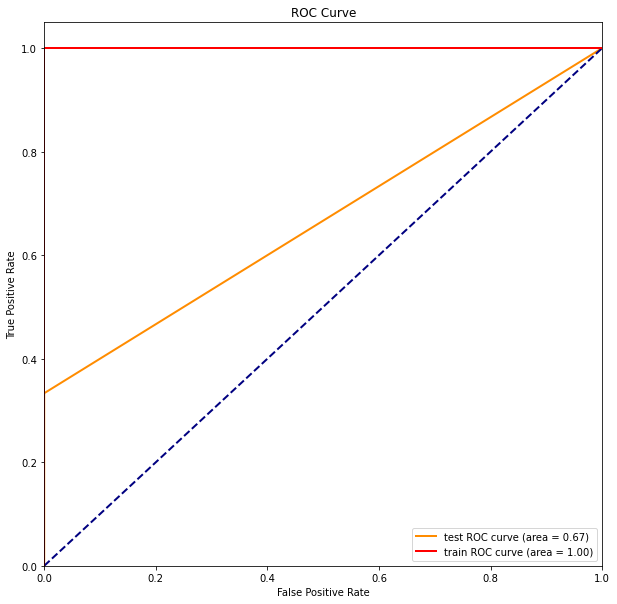


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

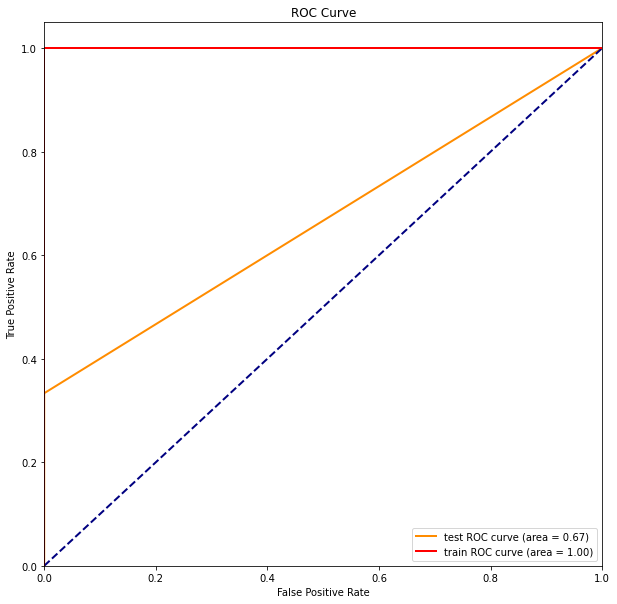


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

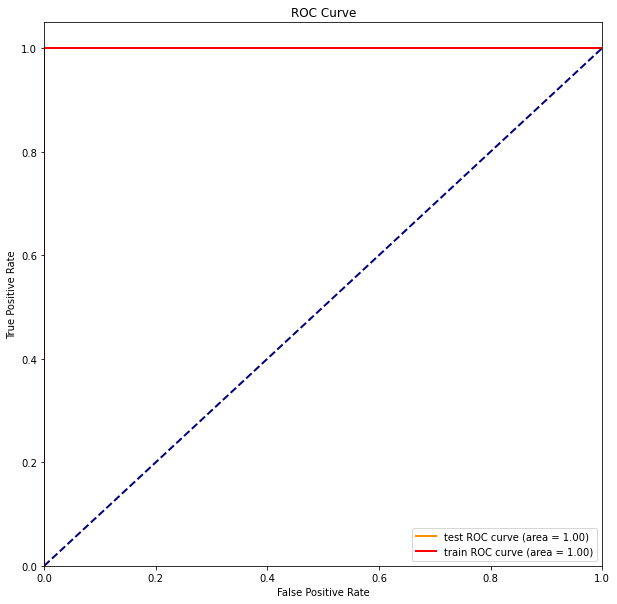


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

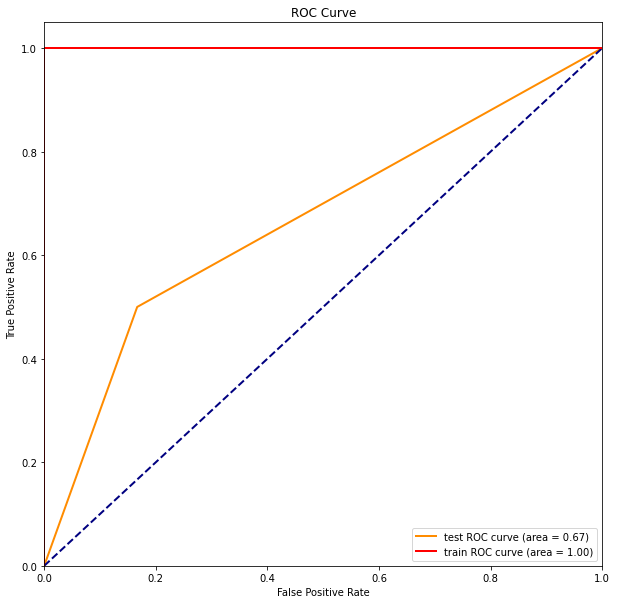


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 0.8333333333333334
specificity: 0.5


<Figure size 432x288 with 0 Axes>

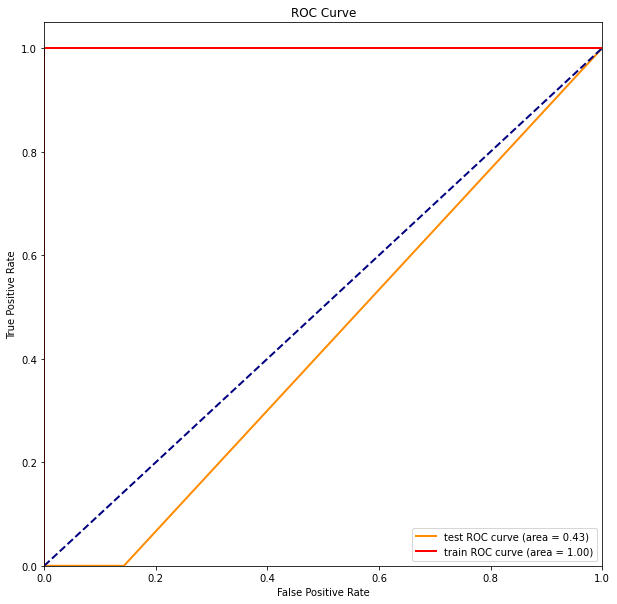


 训练集 1.0 测试集 0.6666666666666666
roc: 0.4285714285714286
sensitivity: 0.8571428571428571
specificity: 0.0


<Figure size 432x288 with 0 Axes>

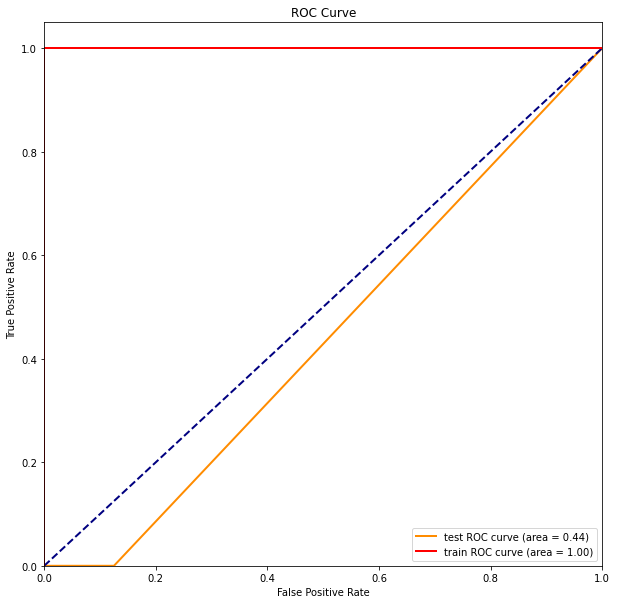


 训练集 1.0 测试集 0.7777777777777778
roc: 0.4375
sensitivity: 0.875
specificity: 0.0


<Figure size 432x288 with 0 Axes>

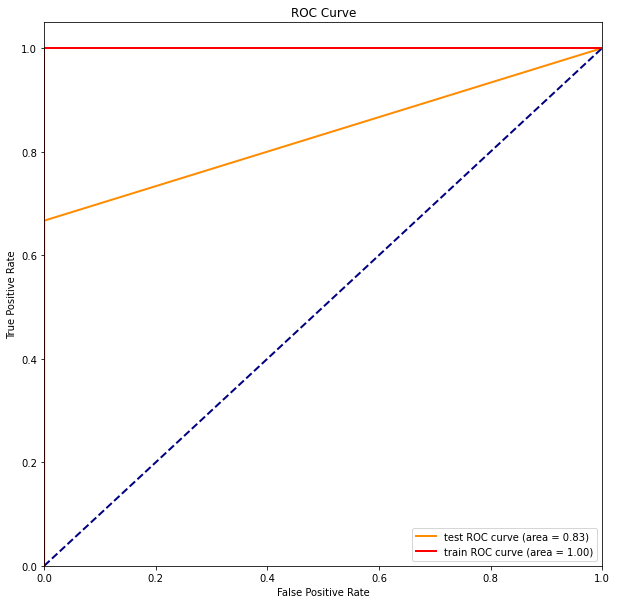


 训练集 1.0 测试集 0.875
roc: 0.8333333333333333
sensitivity: 1.0
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

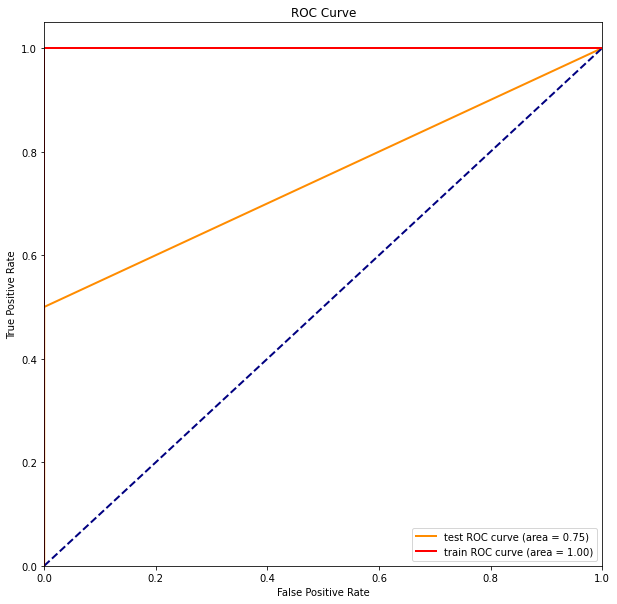


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

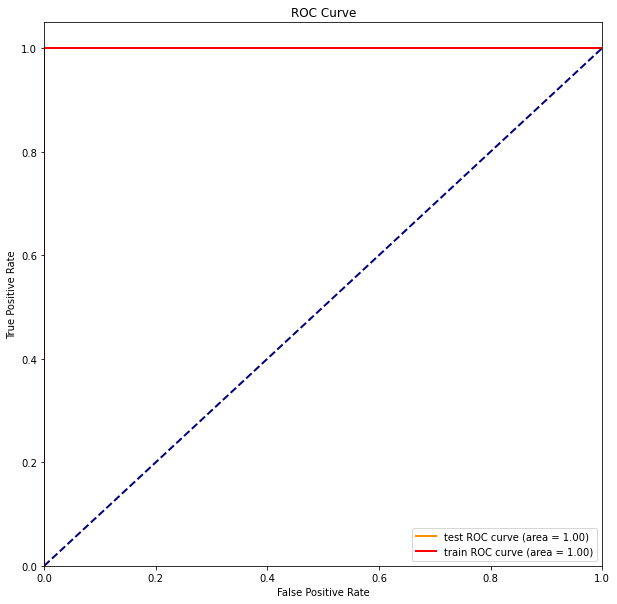


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

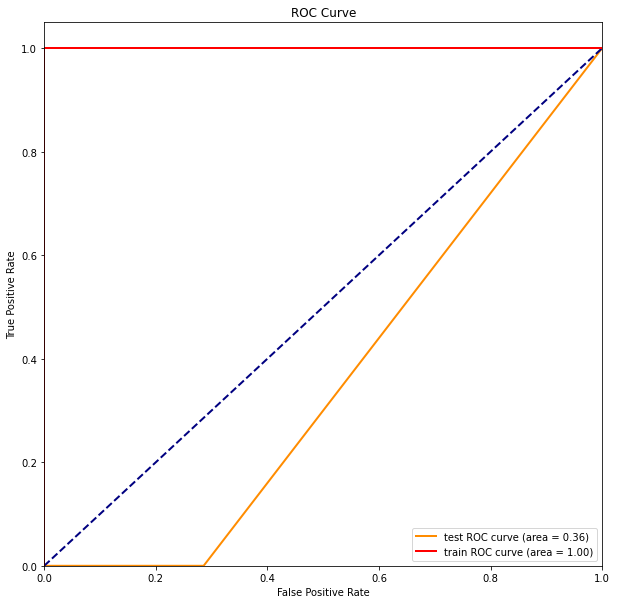


 训练集 1.0 测试集 0.625
roc: 0.35714285714285715
sensitivity: 0.7142857142857143
specificity: 0.0


<Figure size 432x288 with 0 Axes>

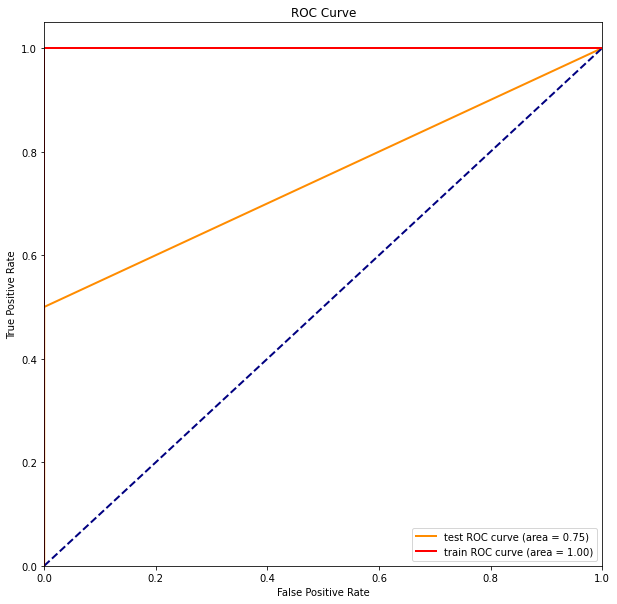


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

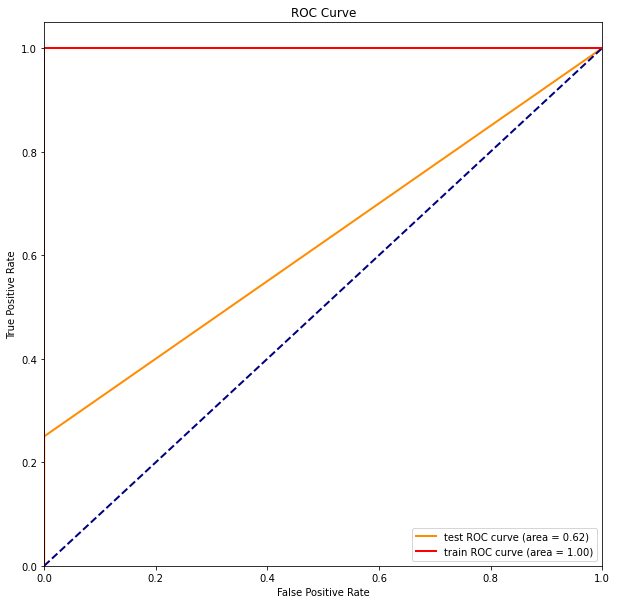


 训练集 1.0 测试集 0.625
roc: 0.625
sensitivity: 1.0
specificity: 0.25


<Figure size 432x288 with 0 Axes>

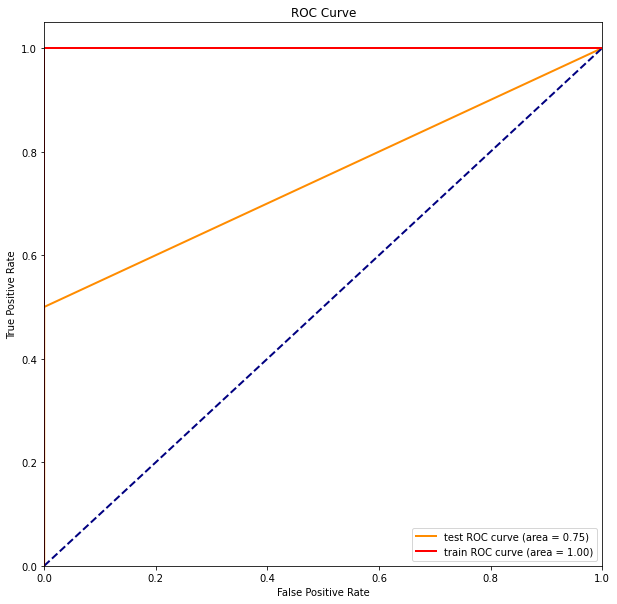


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

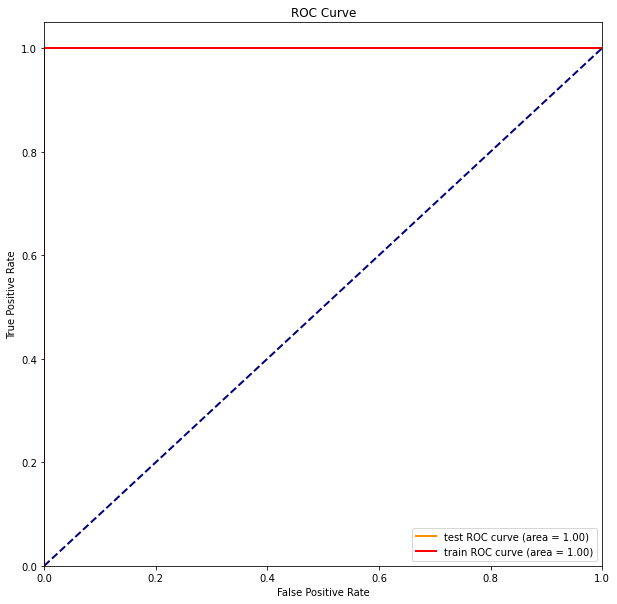


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

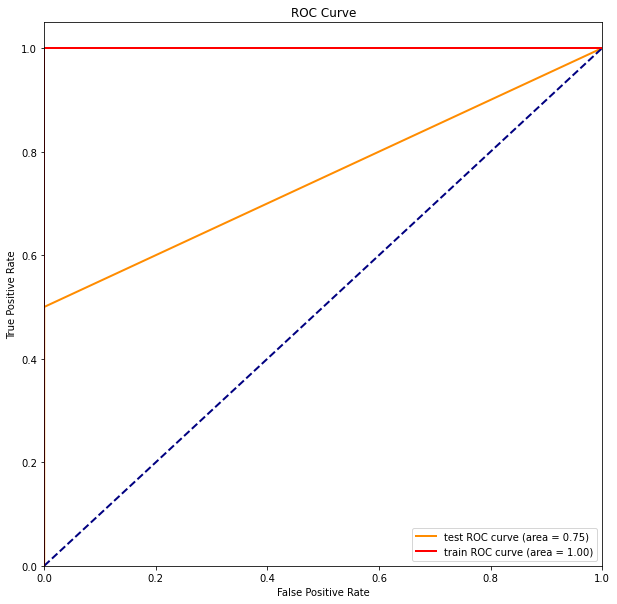


 训练集 1.0 测试集 0.8888888888888888
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

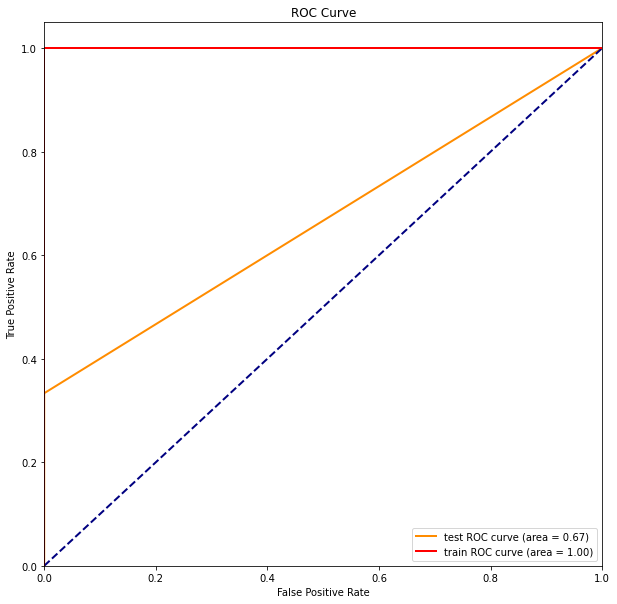


 训练集 1.0 测试集 0.7777777777777778
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

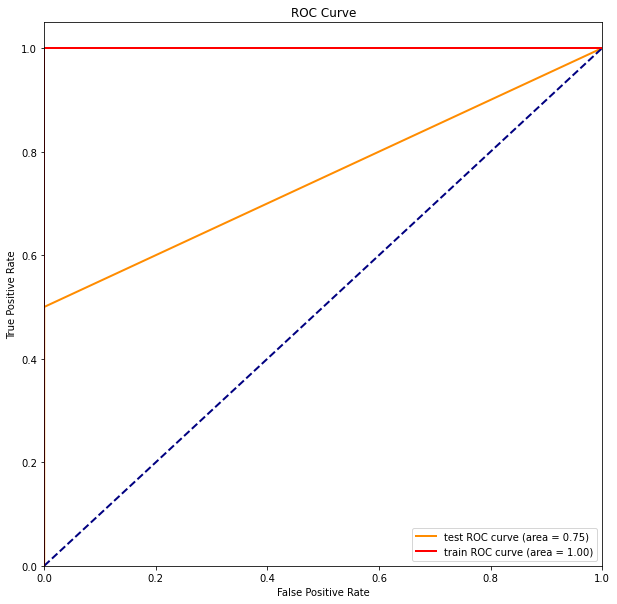


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

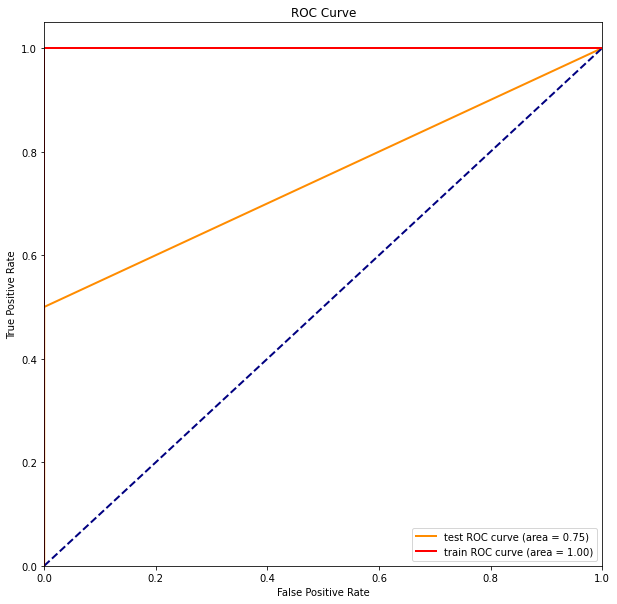


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


D:\Anaconda\envs\lab\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


<Figure size 432x288 with 0 Axes>

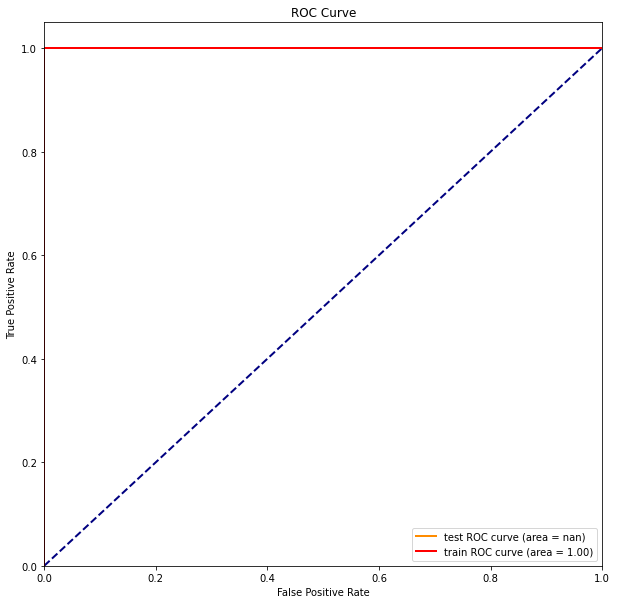


 训练集 1.0 测试集 1.0
roc: 0
sensitivity: 0
specificity: 0


<Figure size 432x288 with 0 Axes>

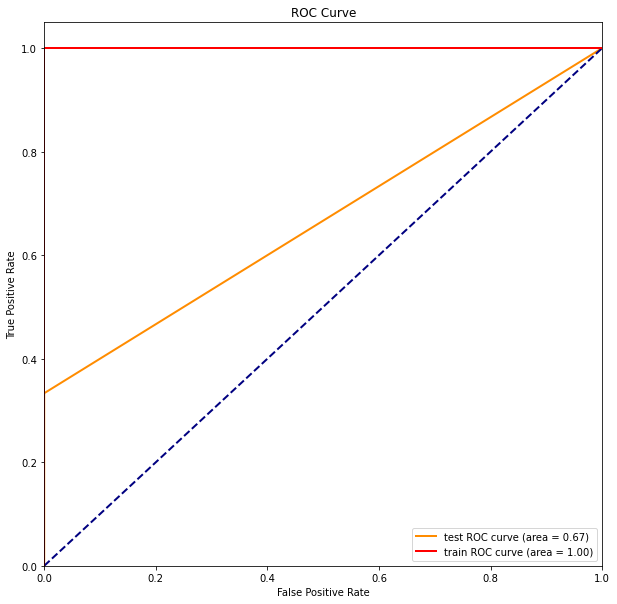


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

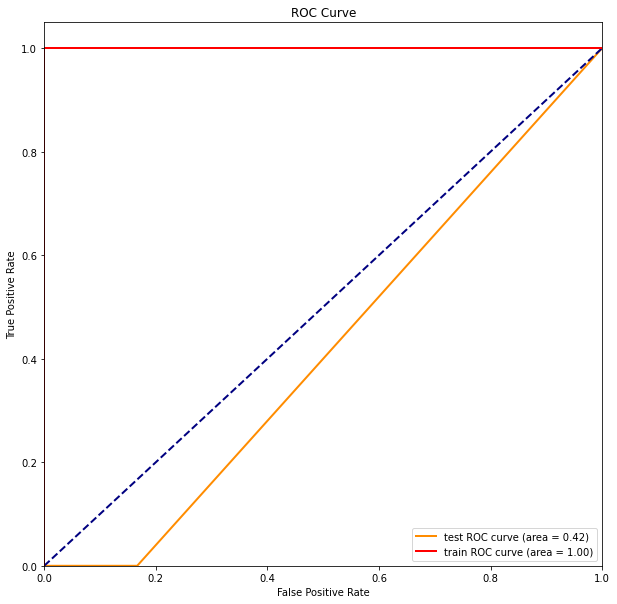


 训练集 1.0 测试集 0.625
roc: 0.4166666666666667
sensitivity: 0.8333333333333334
specificity: 0.0


<Figure size 432x288 with 0 Axes>

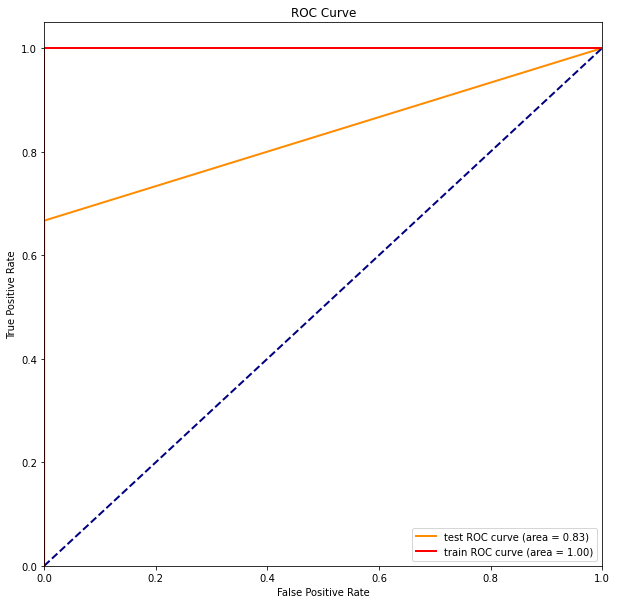


 训练集 1.0 测试集 0.875
roc: 0.8333333333333333
sensitivity: 1.0
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

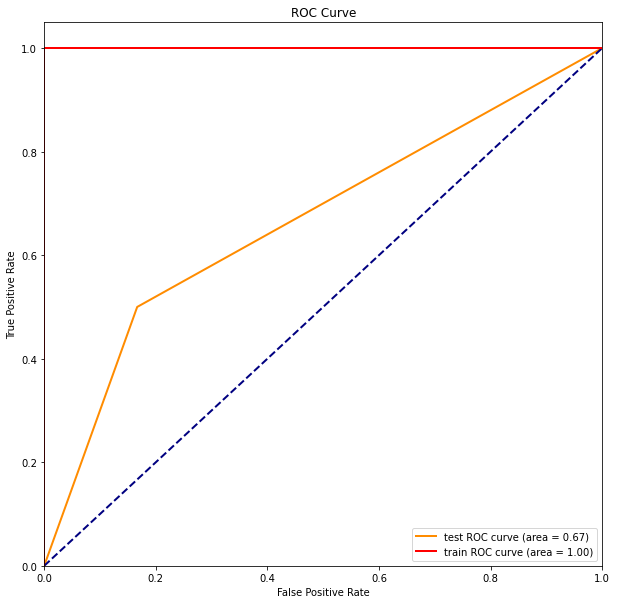


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 0.8333333333333334
specificity: 0.5


<Figure size 432x288 with 0 Axes>

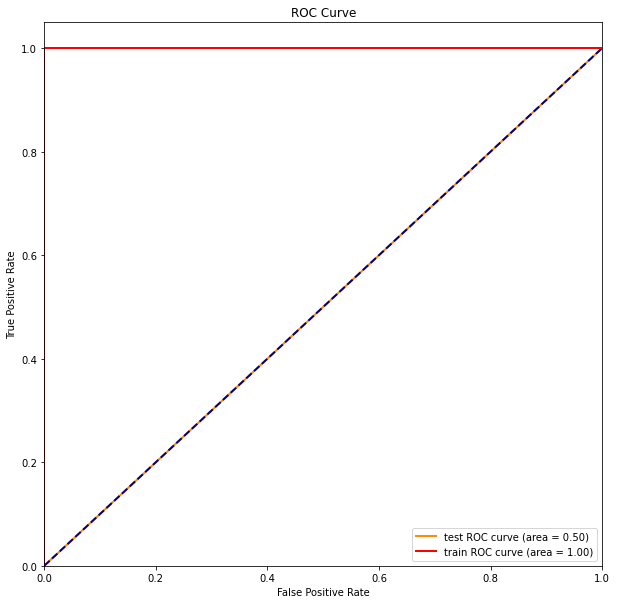


 训练集 1.0 测试集 0.875
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

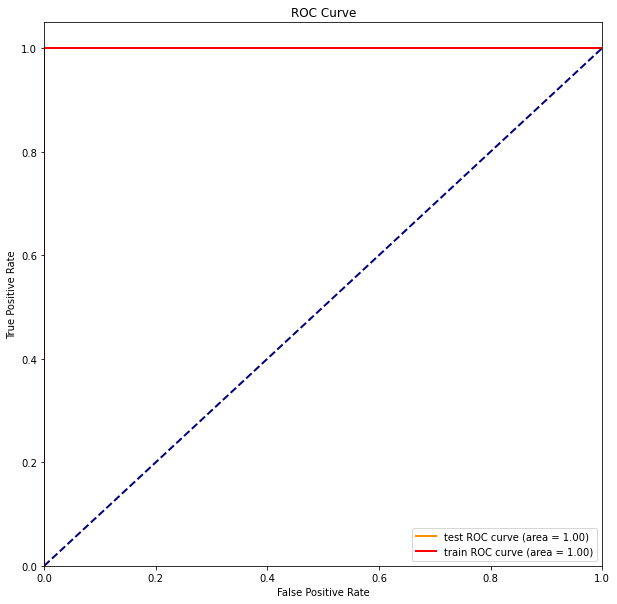


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

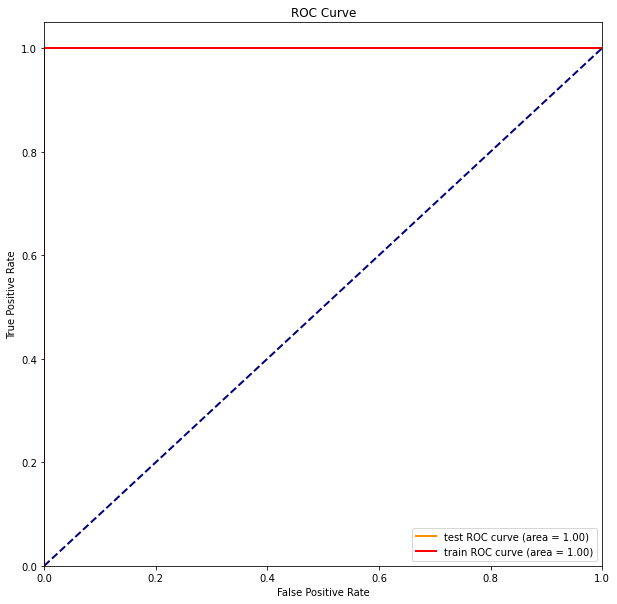


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

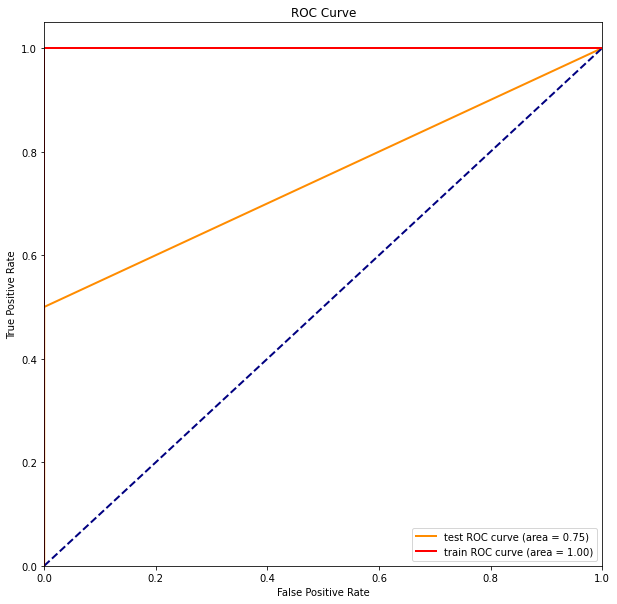


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

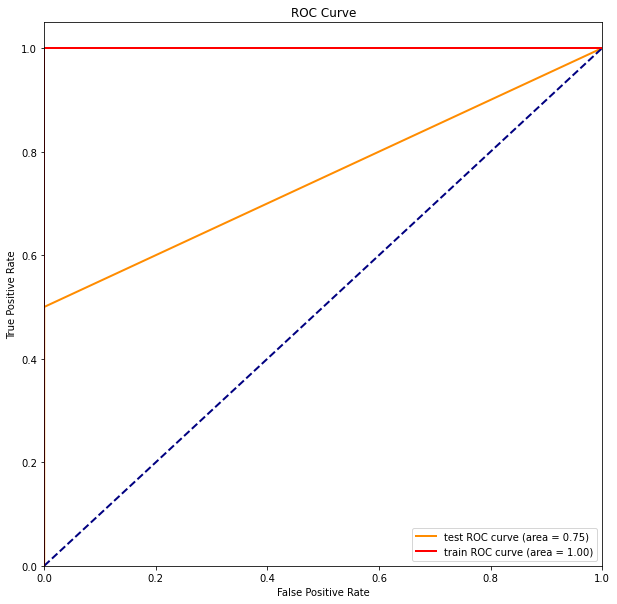


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

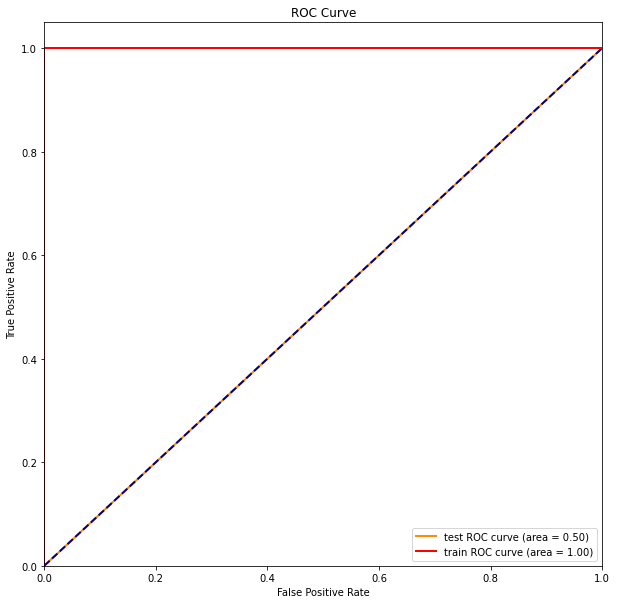


 训练集 1.0 测试集 0.75
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

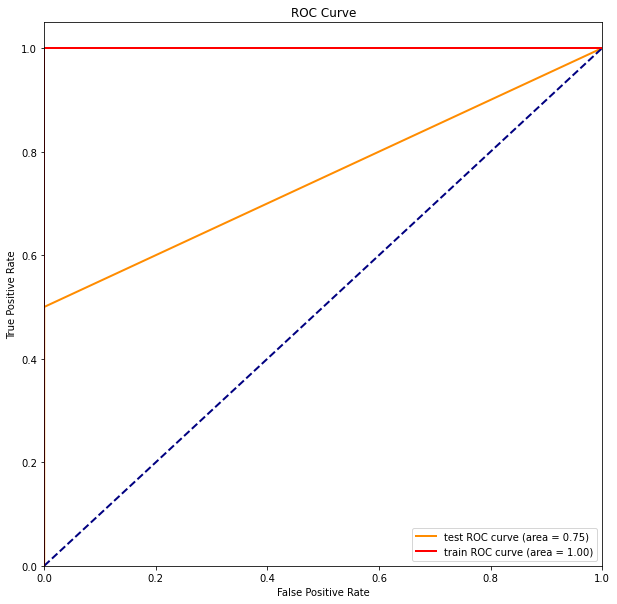


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

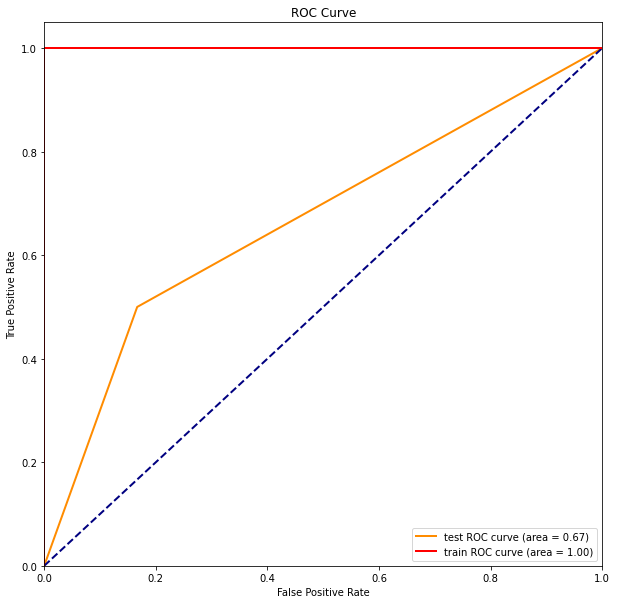


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 0.8333333333333334
specificity: 0.5


<Figure size 432x288 with 0 Axes>

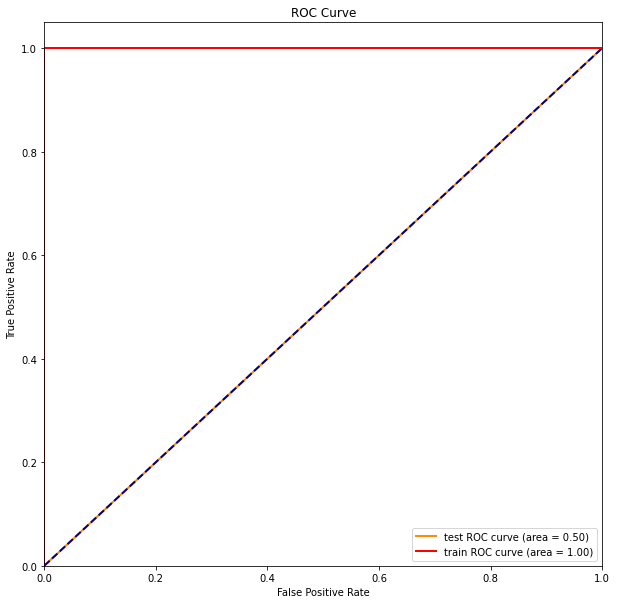


 训练集 1.0 测试集 0.625
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

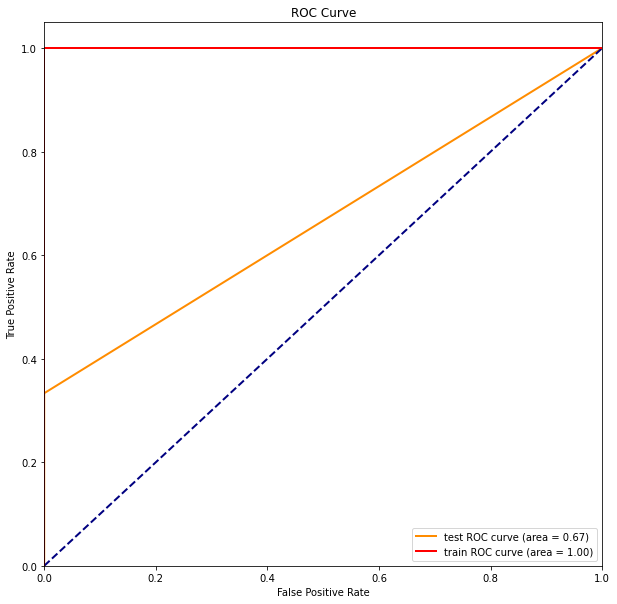


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

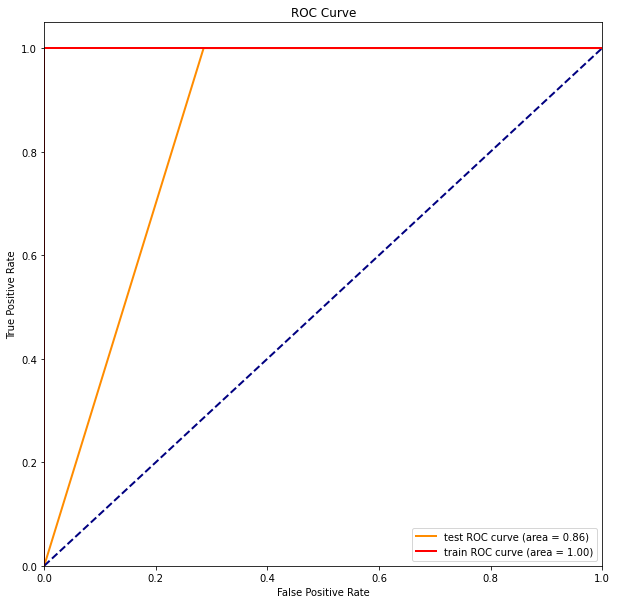


 训练集 1.0 测试集 0.75
roc: 0.8571428571428572
sensitivity: 0.7142857142857143
specificity: 1.0


D:\Anaconda\envs\lab\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


<Figure size 432x288 with 0 Axes>

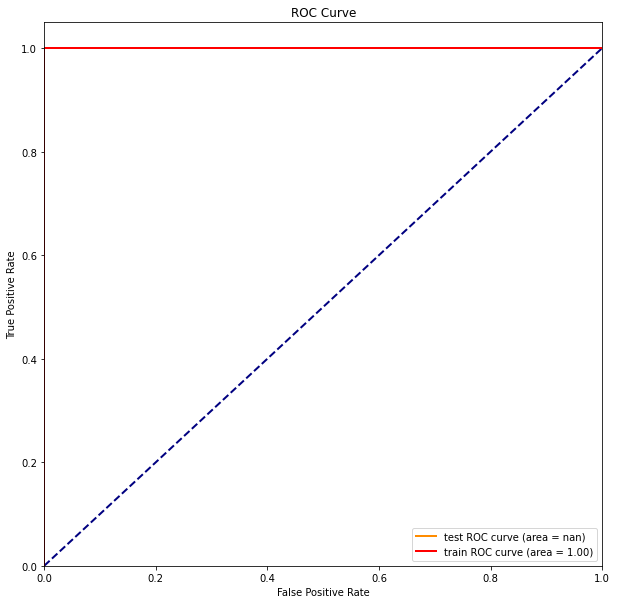


 训练集 1.0 测试集 1.0
roc: 0
sensitivity: 0
specificity: 0


<Figure size 432x288 with 0 Axes>

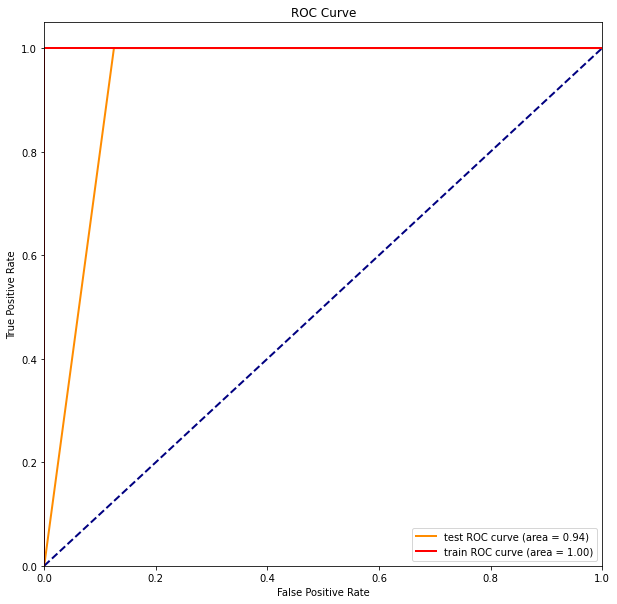


 训练集 1.0 测试集 0.8888888888888888
roc: 0.9375
sensitivity: 0.875
specificity: 1.0


<Figure size 432x288 with 0 Axes>

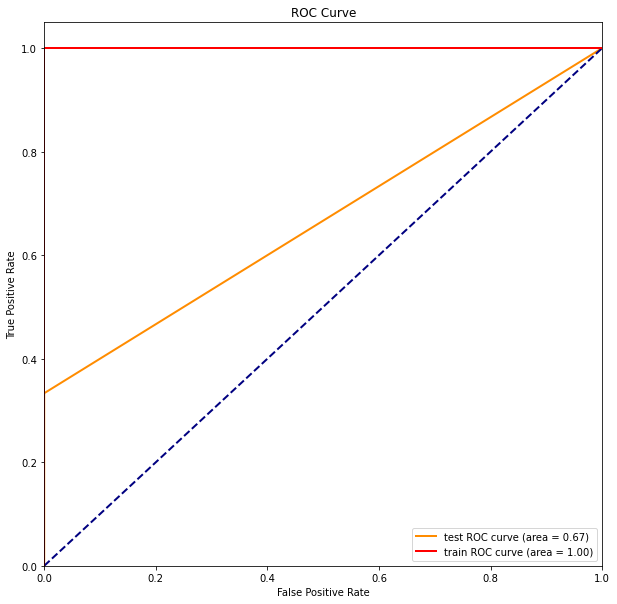


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 1.0
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

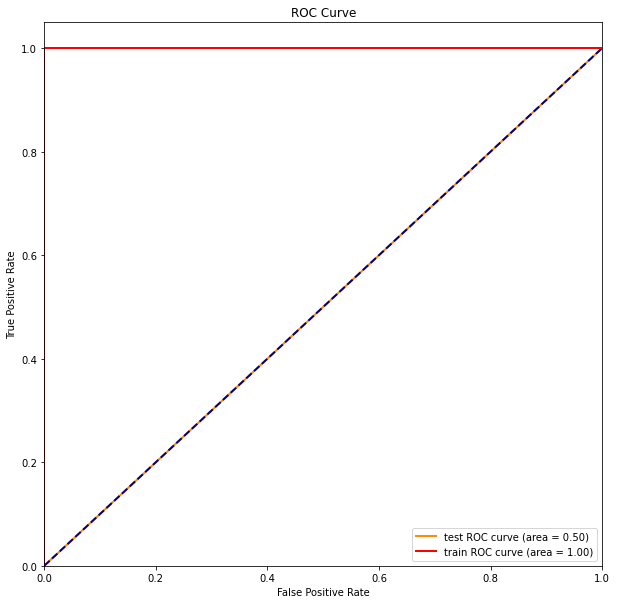


 训练集 1.0 测试集 0.625
roc: 0.5
sensitivity: 1.0
specificity: 0.0


D:\Anaconda\envs\lab\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


<Figure size 432x288 with 0 Axes>

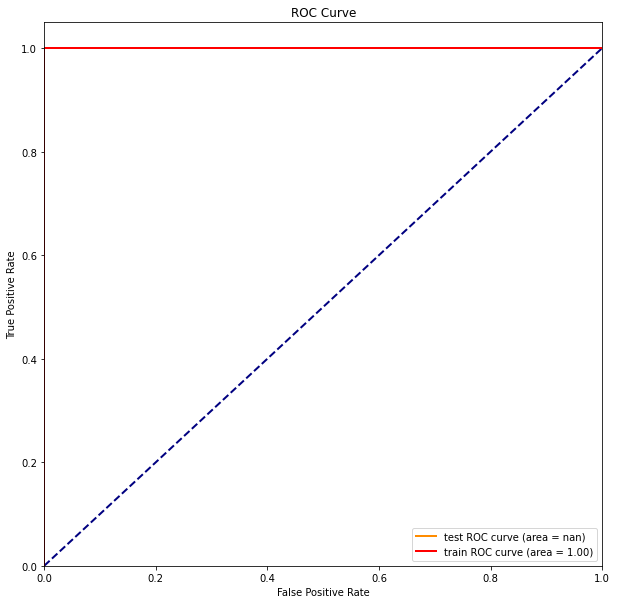


 训练集 1.0 测试集 1.0
roc: 0
sensitivity: 0
specificity: 0


<Figure size 432x288 with 0 Axes>

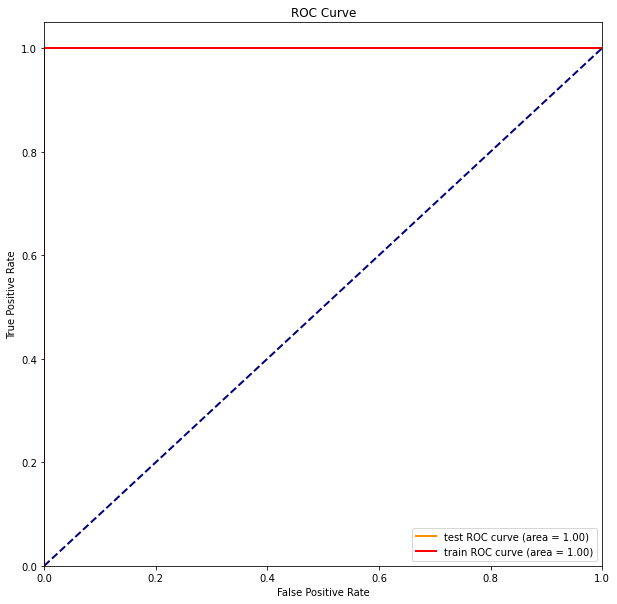


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

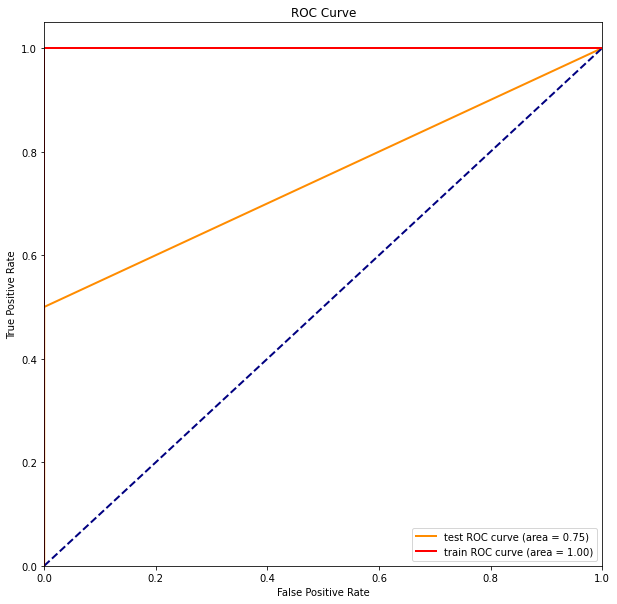


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

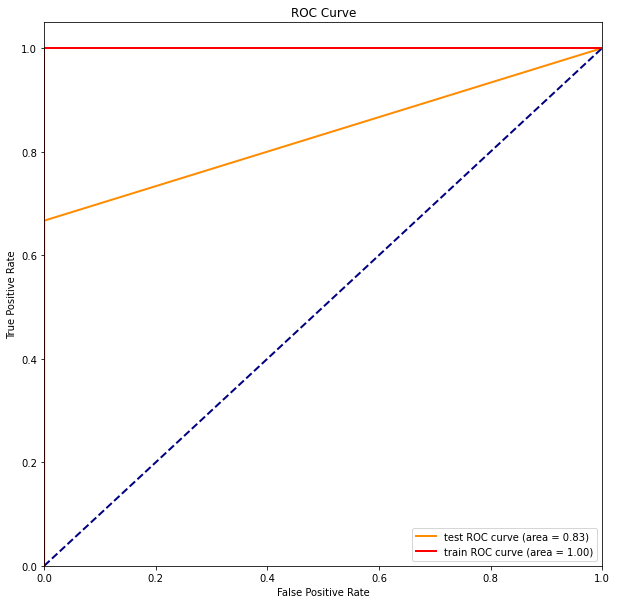


 训练集 1.0 测试集 0.875
roc: 0.8333333333333333
sensitivity: 1.0
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

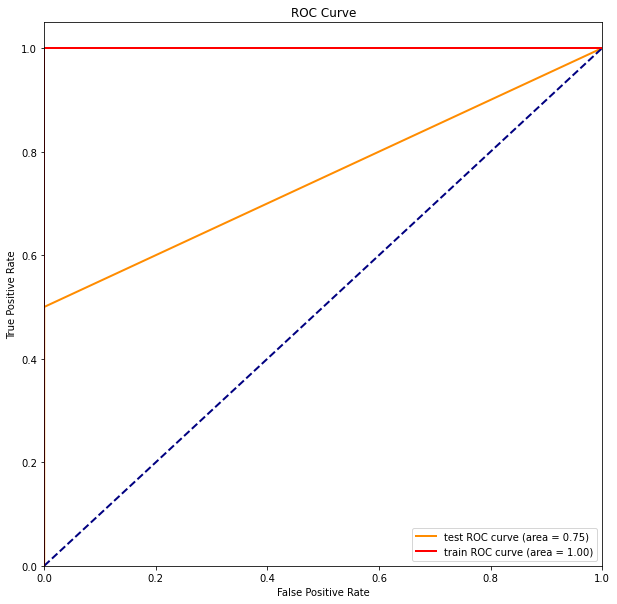


 训练集 1.0 测试集 0.75
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

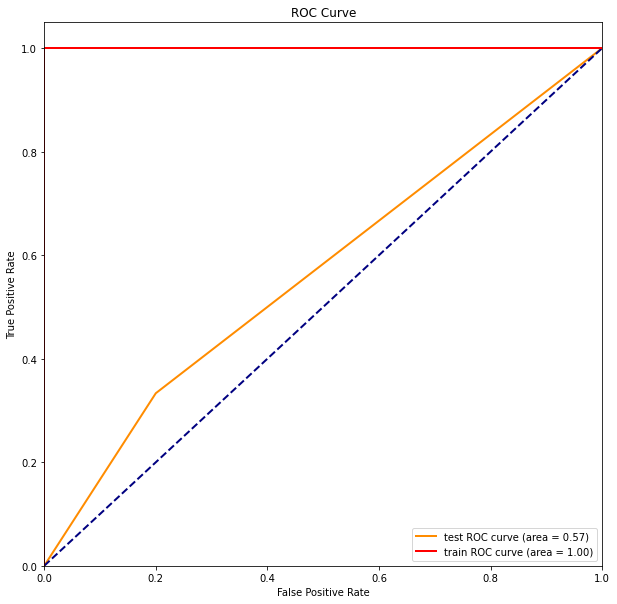


 训练集 1.0 测试集 0.625
roc: 0.5666666666666667
sensitivity: 0.8
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

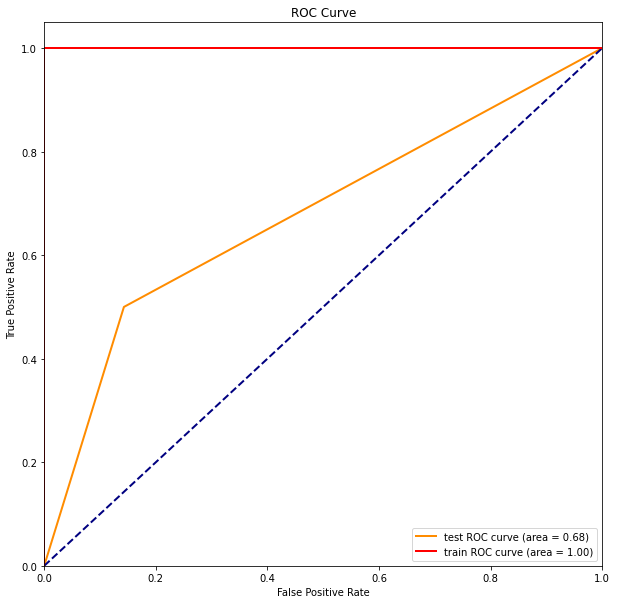


 训练集 1.0 测试集 0.7777777777777778
roc: 0.6785714285714286
sensitivity: 0.8571428571428571
specificity: 0.5


<Figure size 432x288 with 0 Axes>

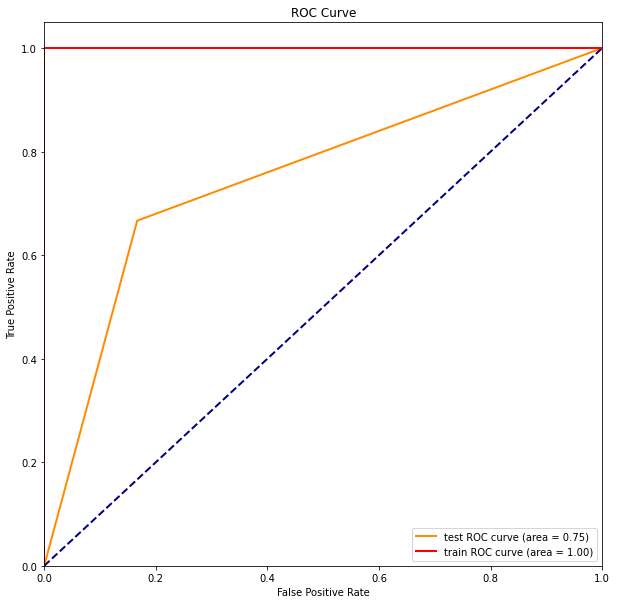


 训练集 1.0 测试集 0.7777777777777778
roc: 0.75
sensitivity: 0.8333333333333334
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

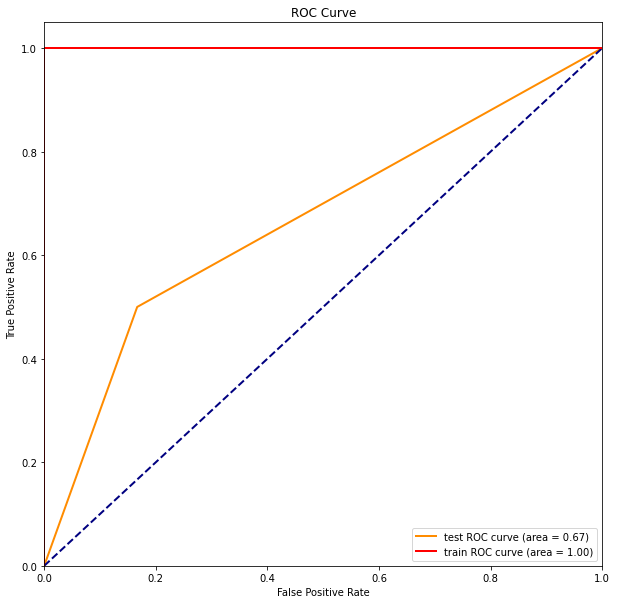


 训练集 1.0 测试集 0.75
roc: 0.6666666666666666
sensitivity: 0.8333333333333334
specificity: 0.5


<Figure size 432x288 with 0 Axes>

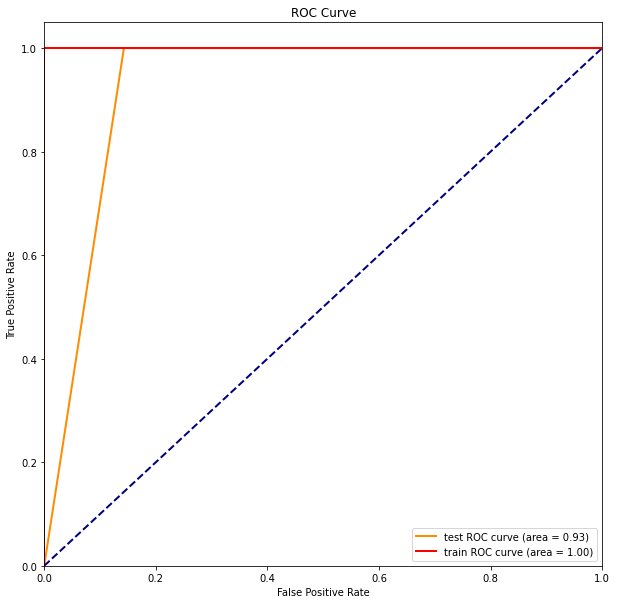


 训练集 1.0 测试集 0.875
roc: 0.9285714285714286
sensitivity: 0.8571428571428571
specificity: 1.0


<Figure size 432x288 with 0 Axes>

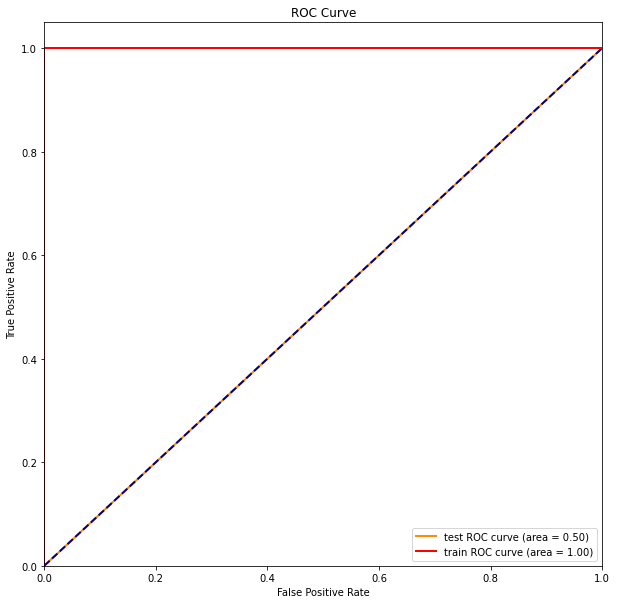


 训练集 1.0 测试集 0.875
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

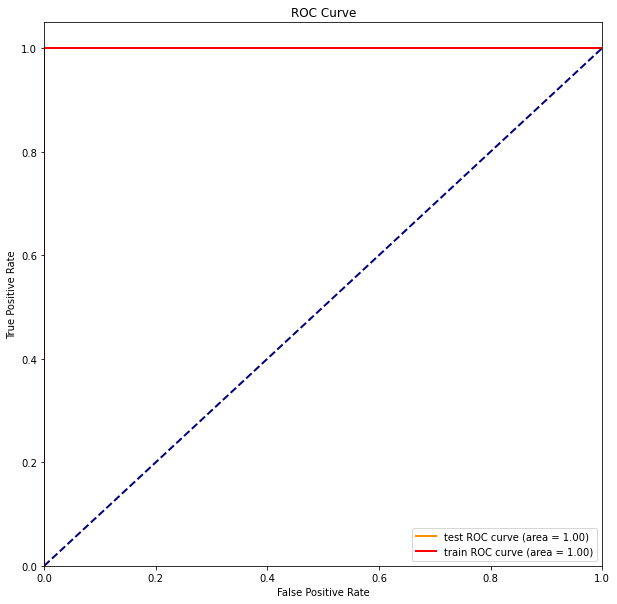


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

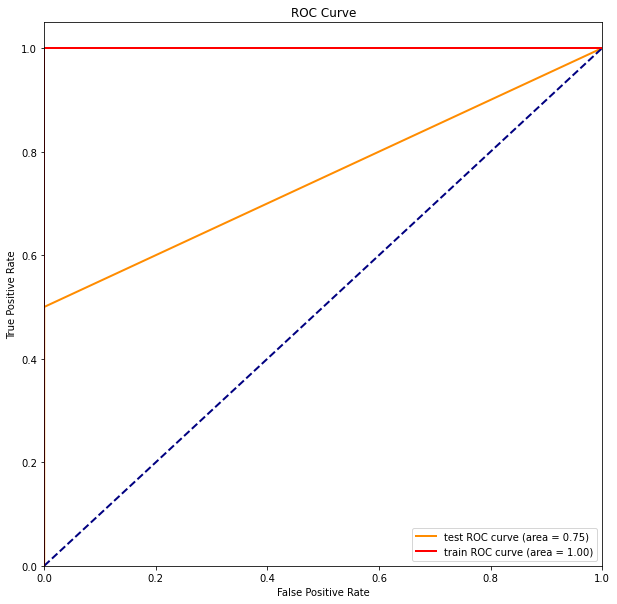


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

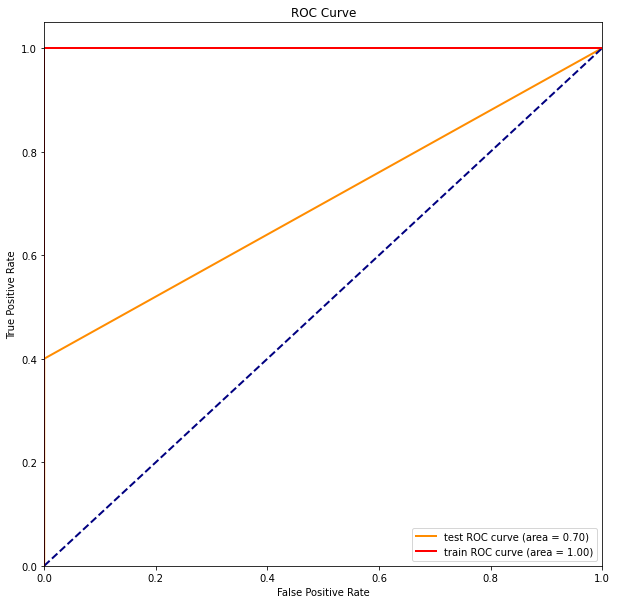


 训练集 1.0 测试集 0.625
roc: 0.7
sensitivity: 1.0
specificity: 0.4


<Figure size 432x288 with 0 Axes>

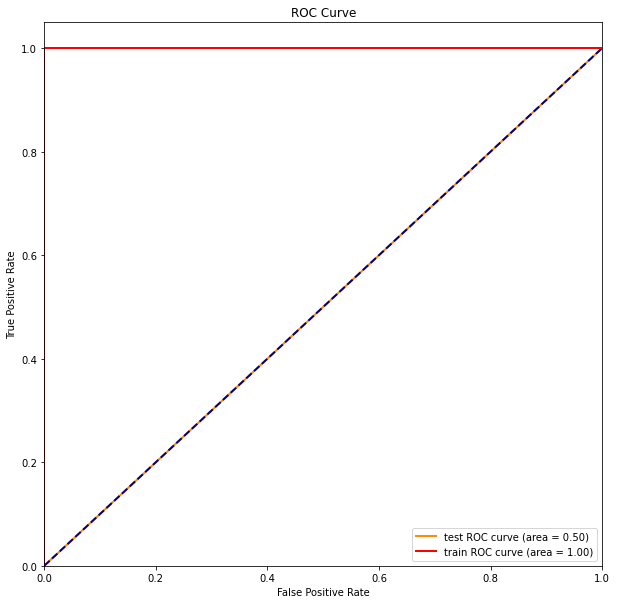


 训练集 1.0 测试集 0.875
roc: 0.5
sensitivity: 1.0
specificity: 0.0


<Figure size 432x288 with 0 Axes>

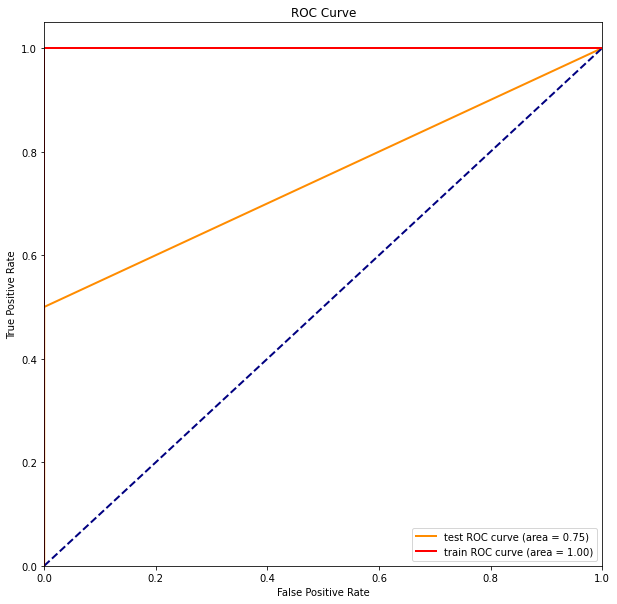


 训练集 1.0 测试集 0.875
roc: 0.75
sensitivity: 1.0
specificity: 0.5
average test accuracy: 0.8336111111111112
average train accuracy: 1.0
average roc: 0.7220043995859214
average sensitivity: 0.9481754658385092
average specificity: 0.6248858447488583


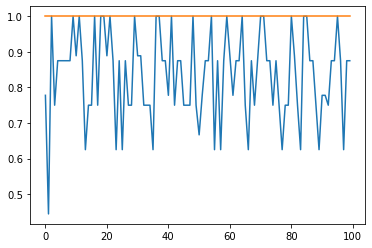

In [93]:
kfold_train_test(10)